In [1]:
import torch
from torchvision import transforms
import torchvision
import numpy as np
from torch.nn import functional as F
import pandas as pd
from tqdm import tqdm
from torchattacks import PGD, FGSM, Pixle
from pathlib import Path
import matplotlib.pyplot as plt
from components.resnet import build_resnet18


SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
root_dir = Path('/home/mathepa1/vscode-projects/mirror-mirror/output/cifar10_class_unlearning_2024_10_21/forget_0')
run_number = 0
unlearning_method = 'amnesiac'

In [3]:
run_dir = root_dir / f'run_{run_number}' 
forget_set = run_dir / 'forget_set.csv'
orig_model_path = root_dir.parent / 'original' / 'original_state_dict.pt'
unlearned_model_path, control_model_path = run_dir / unlearning_method / f'{unlearning_method}_state_dict.pt', run_dir / 'control' / 'control_state_dict.pt'

In [4]:
ds_index = pd.read_csv(str(forget_set))['sample_ind'].to_numpy()
CIFAR_MEAN, CIFAR_STD = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    ]
)
clean_ds = torchvision.datasets.CIFAR10('./data', transform=transform, download=True)
clean_ds = torch.utils.data.Subset(clean_ds, ds_index)

100%|██████████| 170498071/170498071 [00:02<00:00, 70414578.42it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
orig_model, control_model, unlearned_model = build_resnet18(10, 3).cuda(), build_resnet18(10, 3).cuda(), build_resnet18(10, 3).cuda()
orig_model.load_state_dict(torch.load(str(orig_model_path)))
control_model.load_state_dict(torch.load(str(control_model_path)))
unlearned_model.load_state_dict(torch.load(str(unlearned_model_path)))
orig_model.eval()
control_model.eval()
unlearned_model.eval();

In [6]:
def plot_img(img, ax):
    ax.imshow((img.permute(1, 2, 0).cpu() * np.array(CIFAR_STD)) + np.array(CIFAR_MEAN))

In [7]:
def get_adv_imgs(model, clean_ds):
    atk = Pixle(model)
    print(atk.device)
    atk.set_device(torch.device('cuda:0'))
    atk.set_normalization_used(CIFAR_MEAN, CIFAR_STD)
    atk.set_mode_targeted_by_function(lambda x, y: y)

    test_dl = torch.utils.data.DataLoader(clean_ds, batch_size=128)
    adv_imgs = []
    num_correct = 0
    for imgs, labels in test_dl:
        batch_adv_imgs = atk(imgs, labels)
        preds = F.softmax(model(batch_adv_imgs.float().cuda()), dim=-1).argmax(dim=-1)
        num_correct += torch.sum(preds.cpu() == labels).item()
        adv_imgs.extend(batch_adv_imgs)    
    adv_imgs = torch.stack(adv_imgs)
    asr = num_correct / adv_imgs.shape[0]
    
    return asr, adv_imgs

In [8]:
asr, adv_imgs = get_adv_imgs(unlearned_model, clean_ds)
print(f'Attack Success Rate: {asr * 100:.4f}%')

cuda:0
Attack mode is changed to 'targeted(custom)'.


KeyboardInterrupt: 

100%|██████████| 300/300 [00:01<00:00, 275.61it/s]


Found 163 examples of recovered behavior


  0%|          | 0/163 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  1%|          | 2/163 [00:00<00:09, 16.57it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  4%|▎         | 6/163 [00:00<00:10, 15.55it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  7%|▋         | 12/163 [00:00<00:09, 16.00it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow

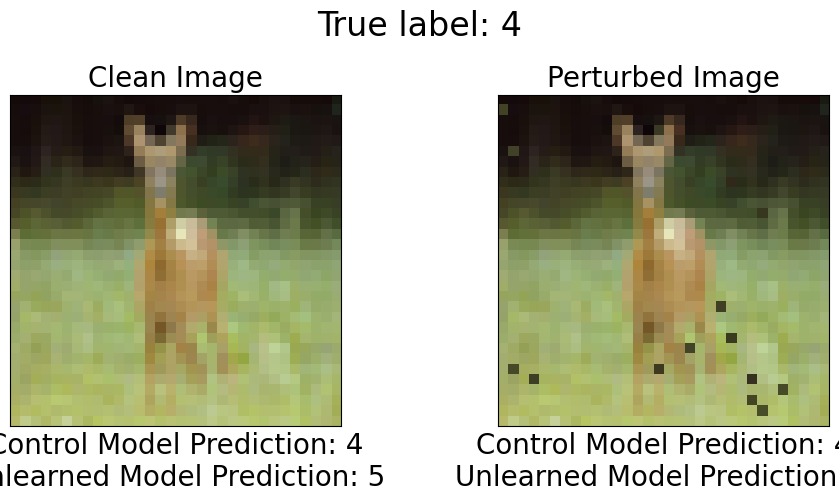

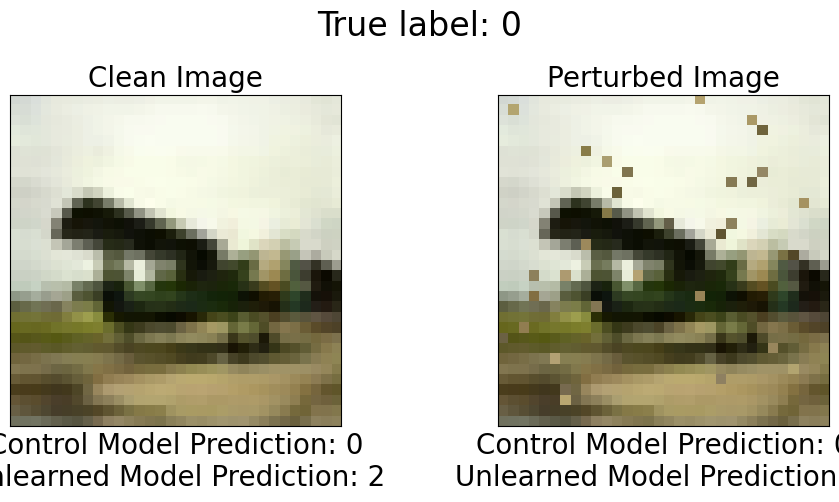

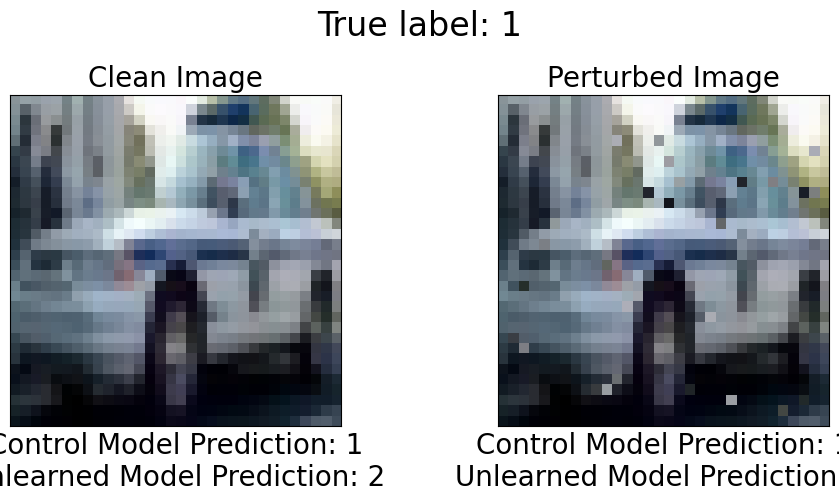

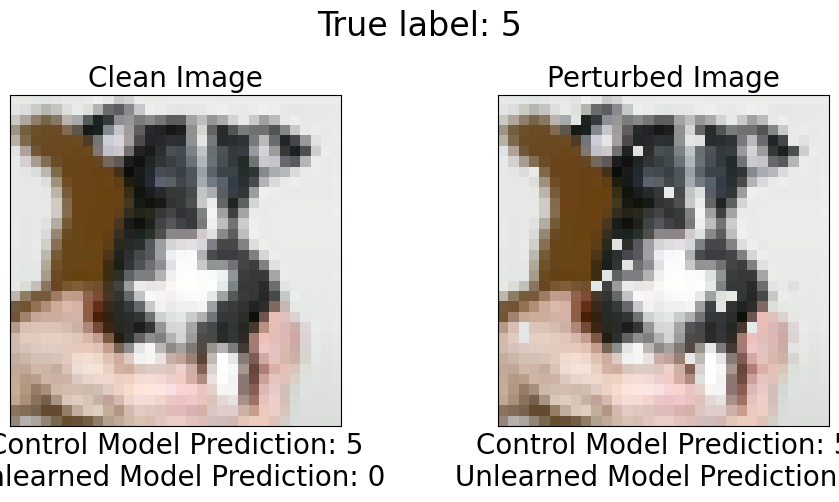

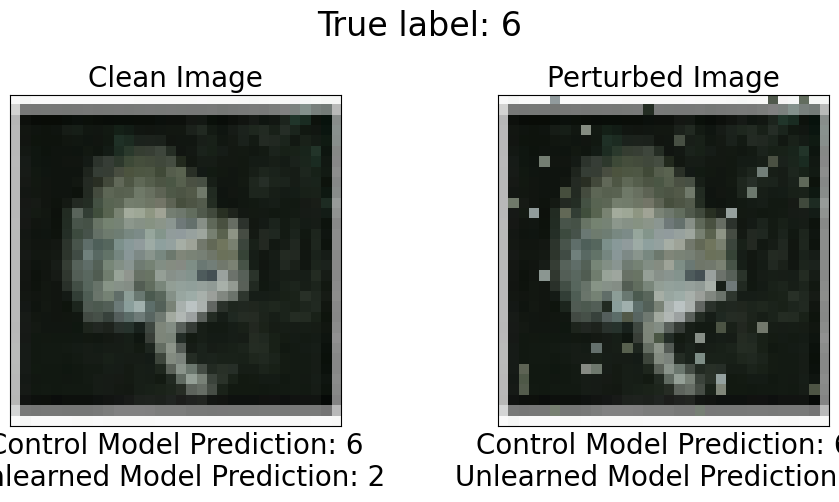

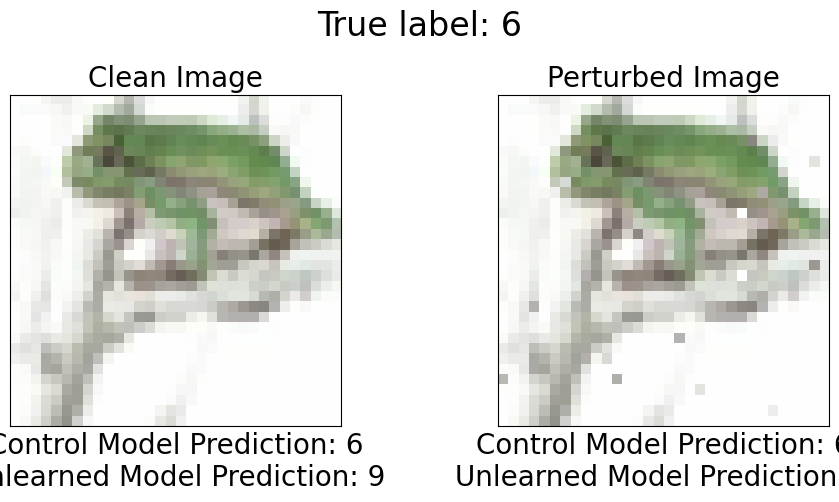

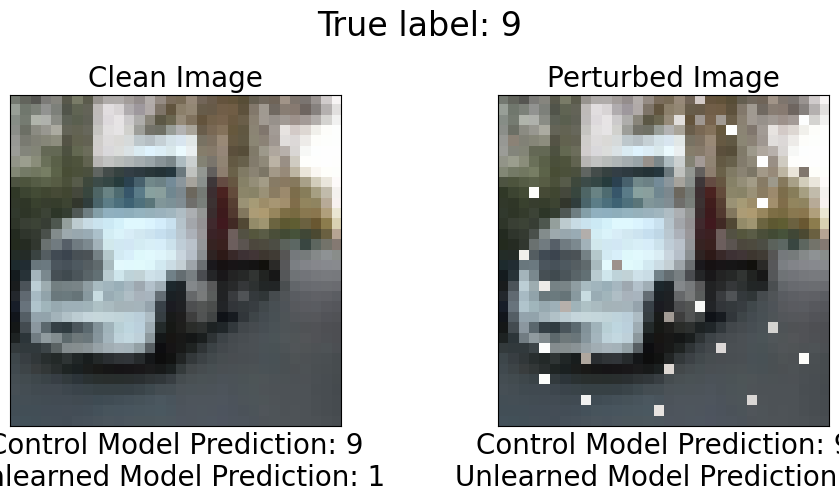

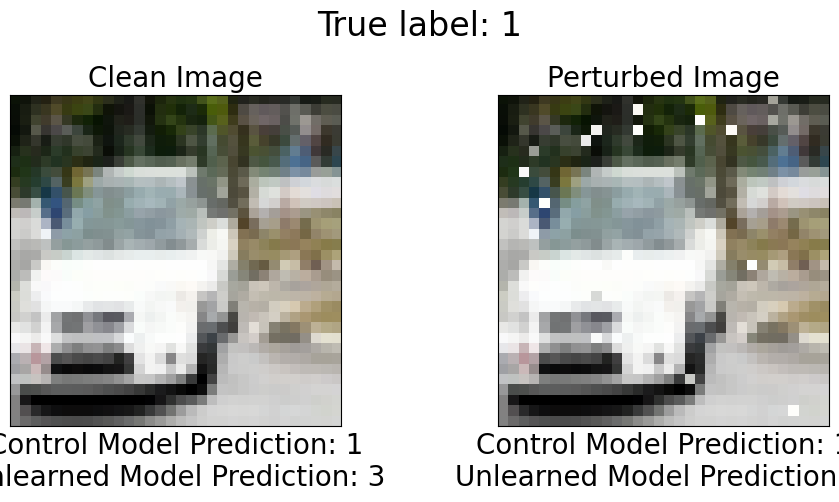

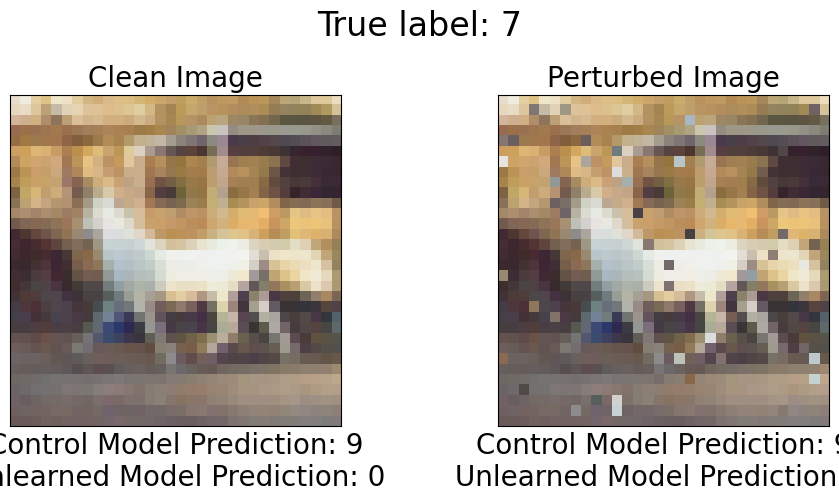

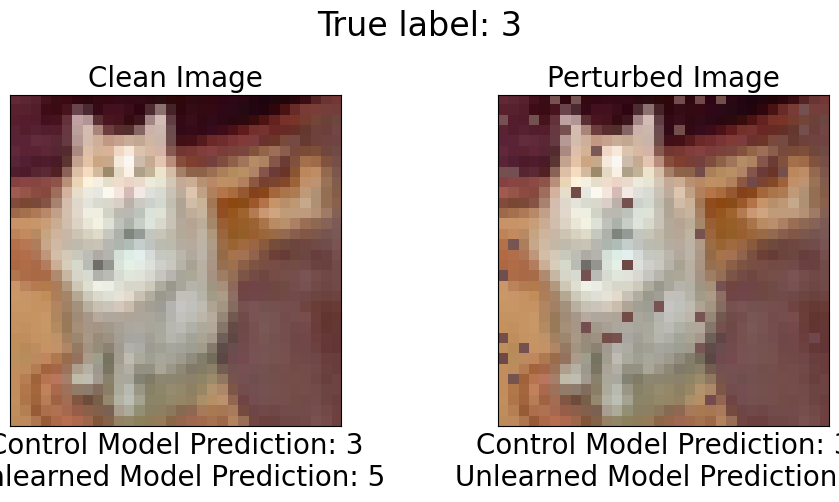

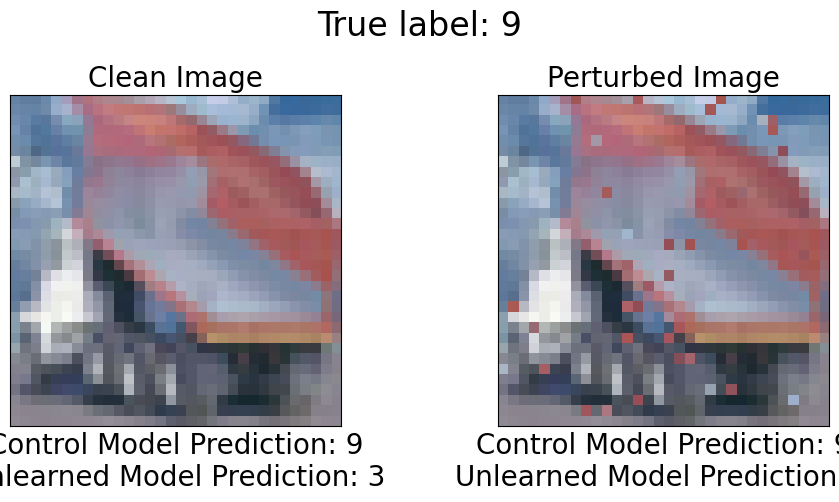

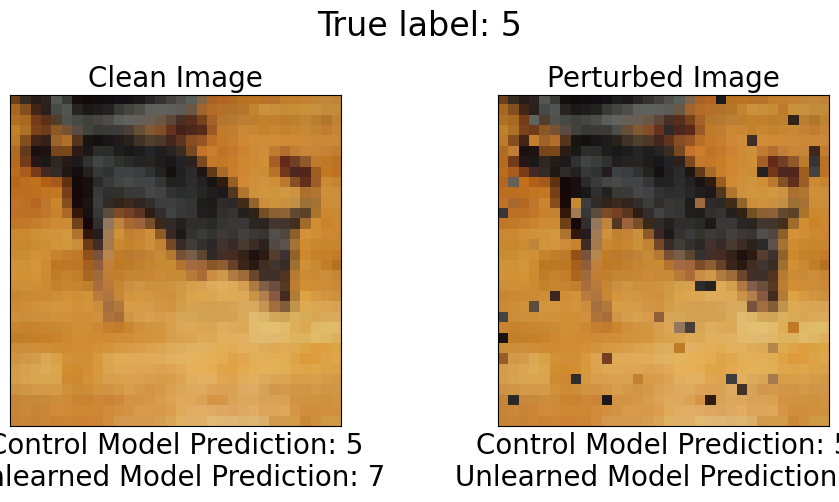

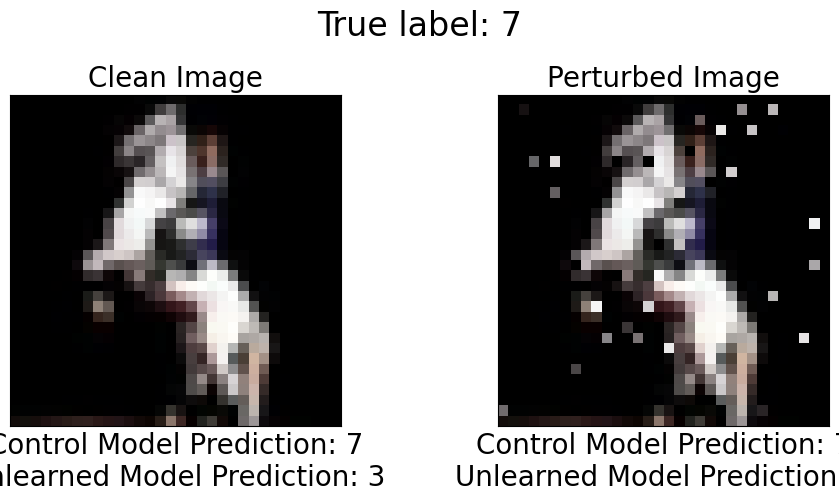

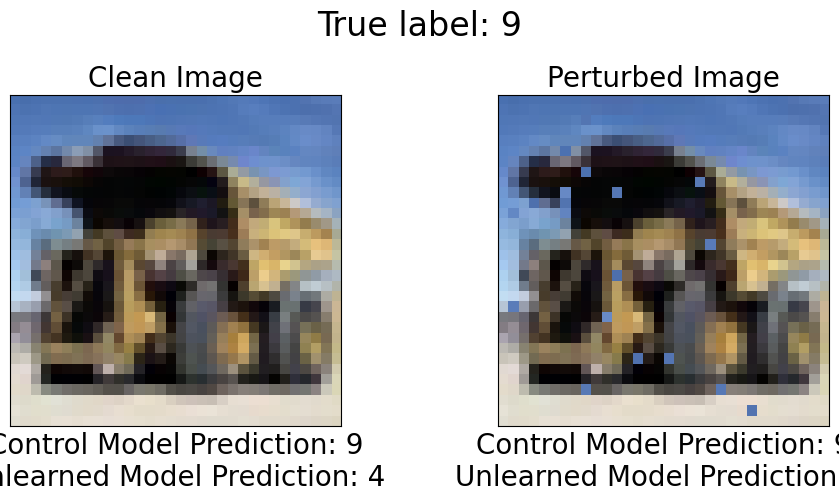

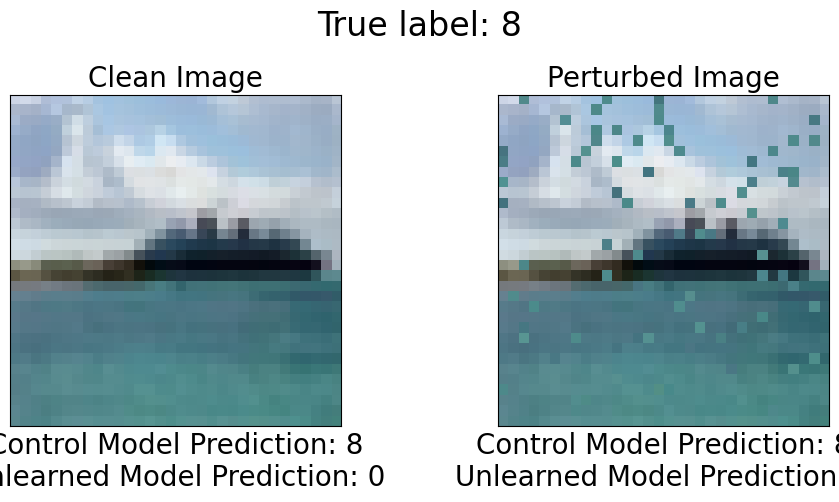

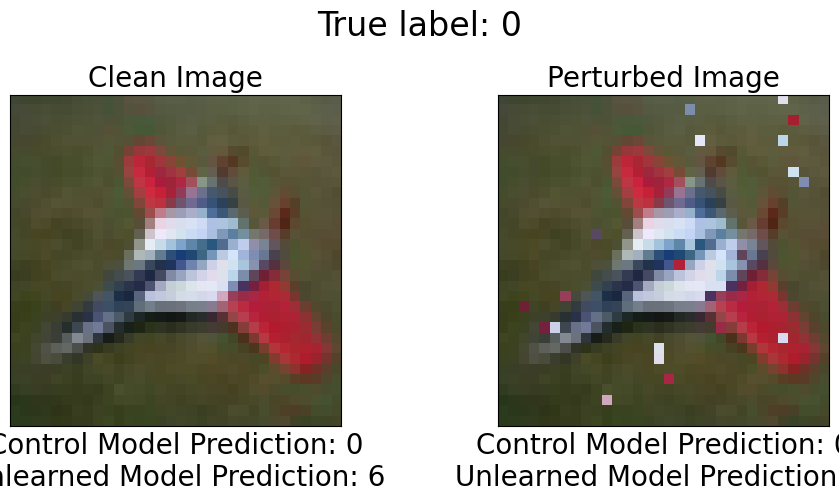

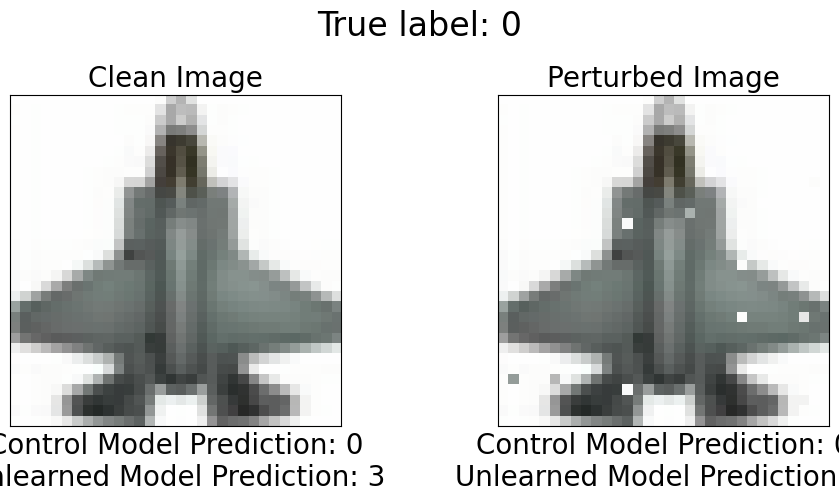

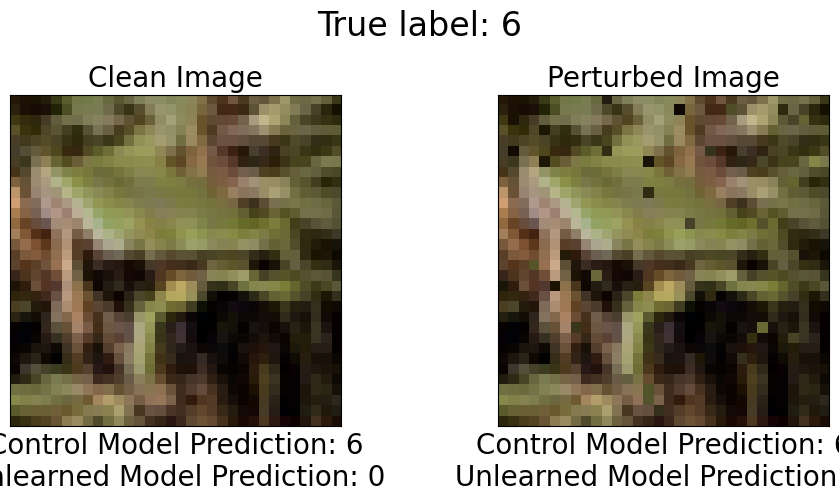

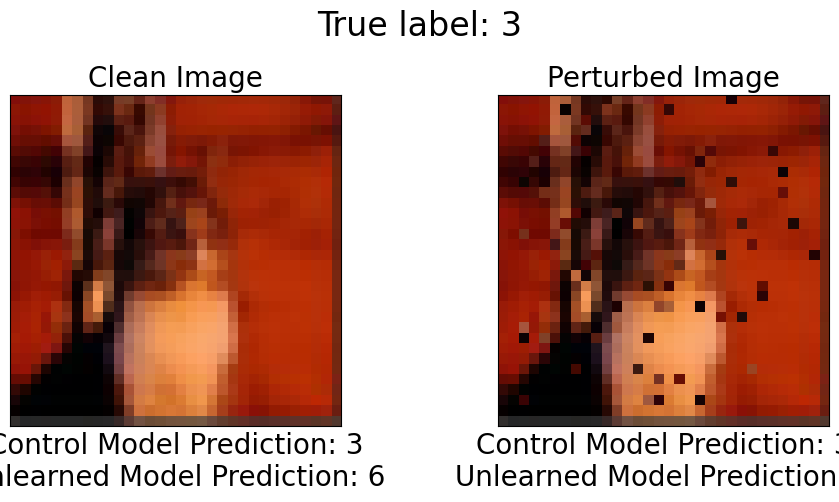

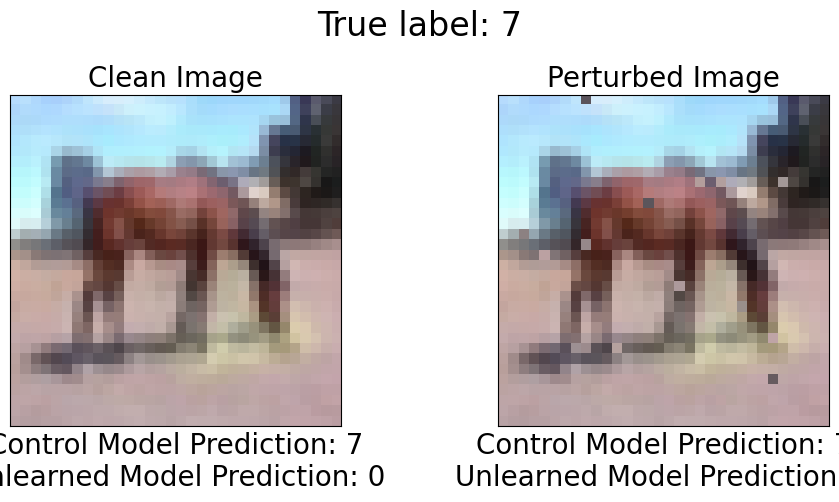

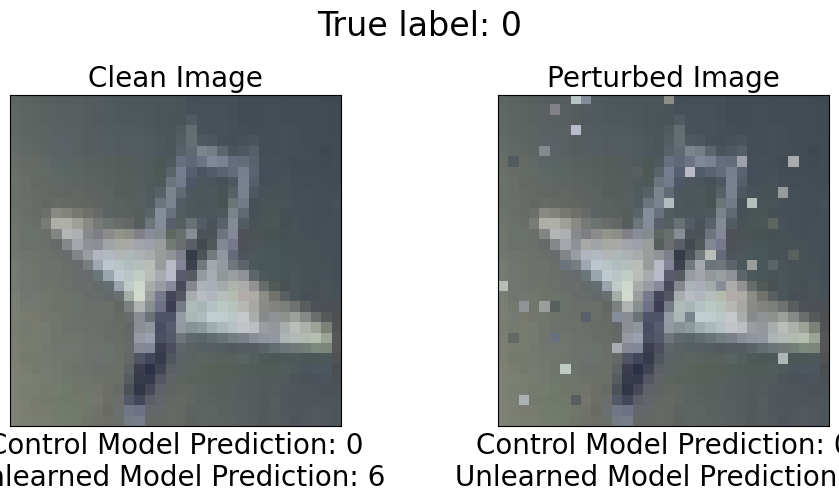

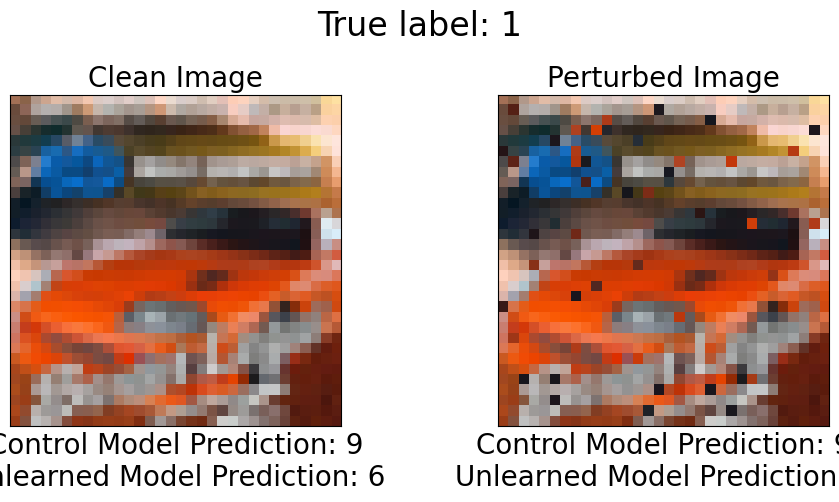

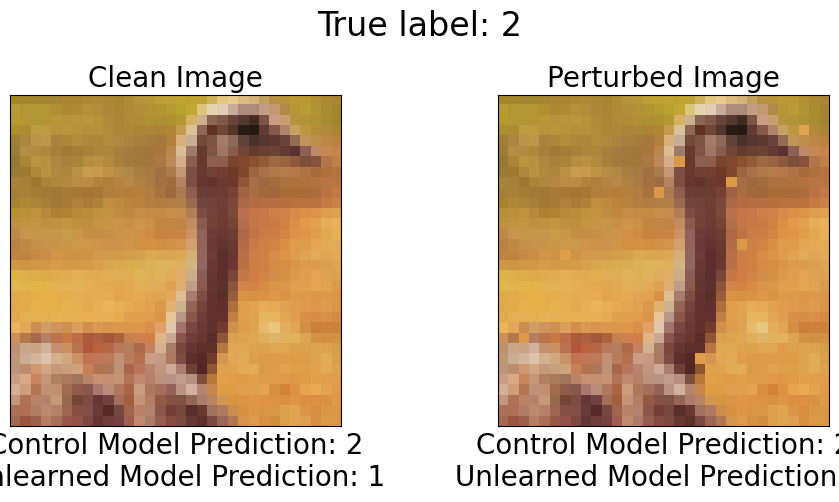

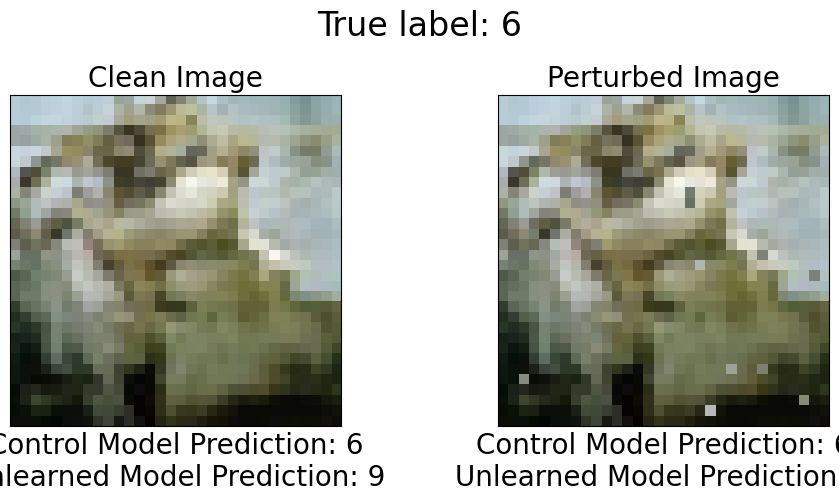

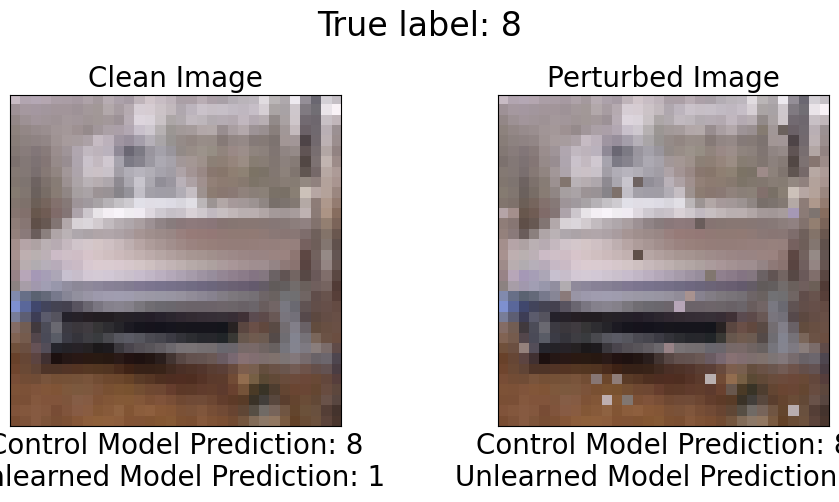

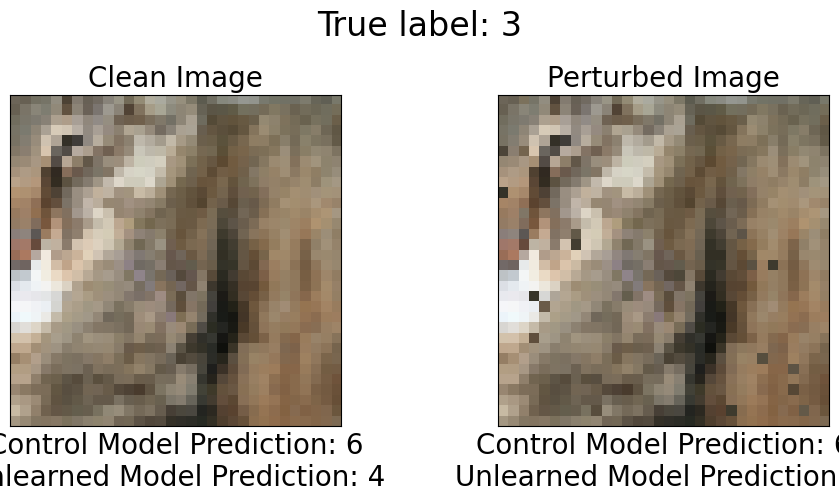

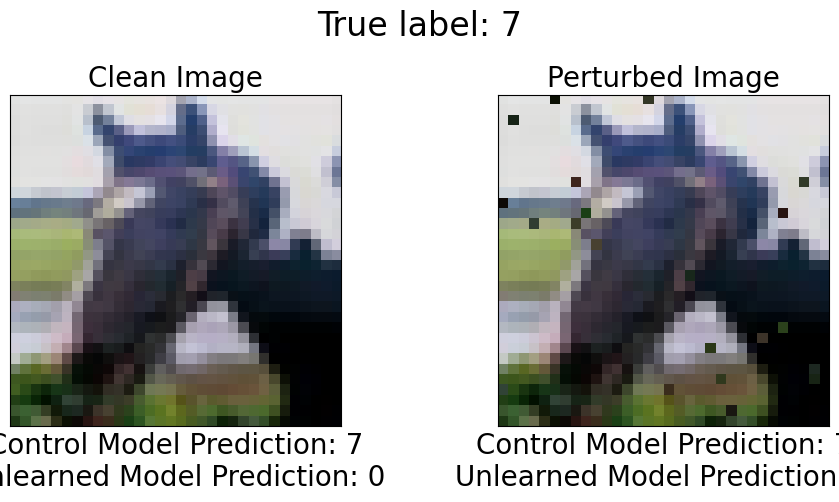

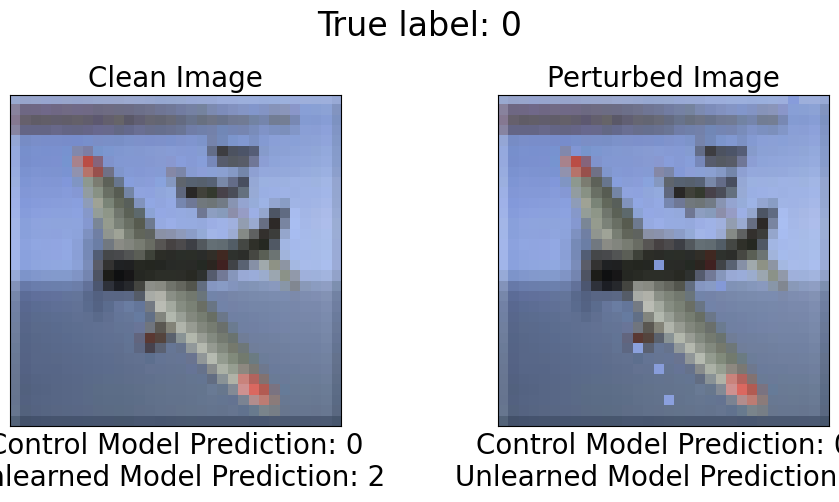

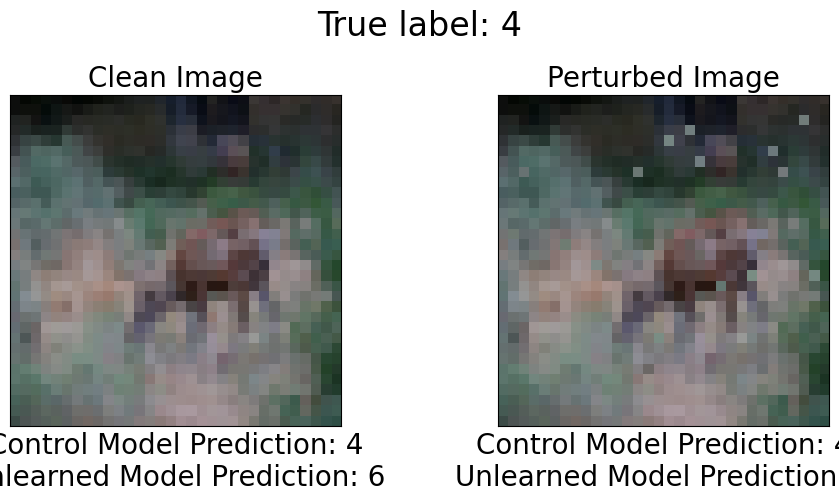

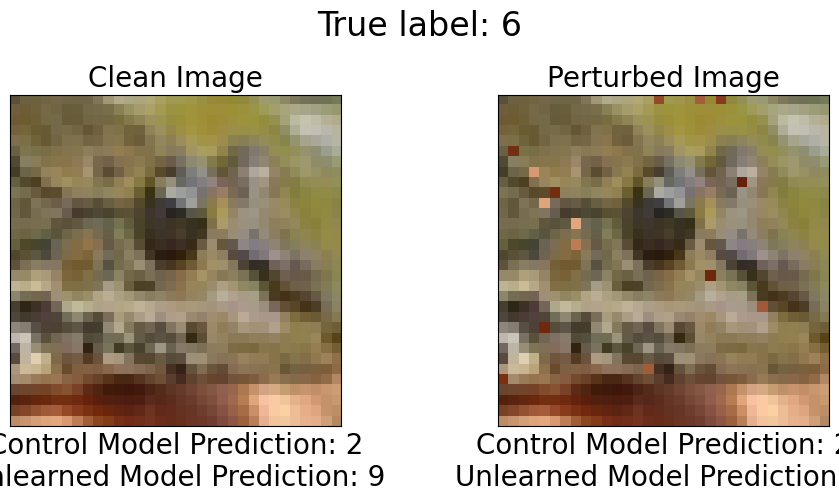

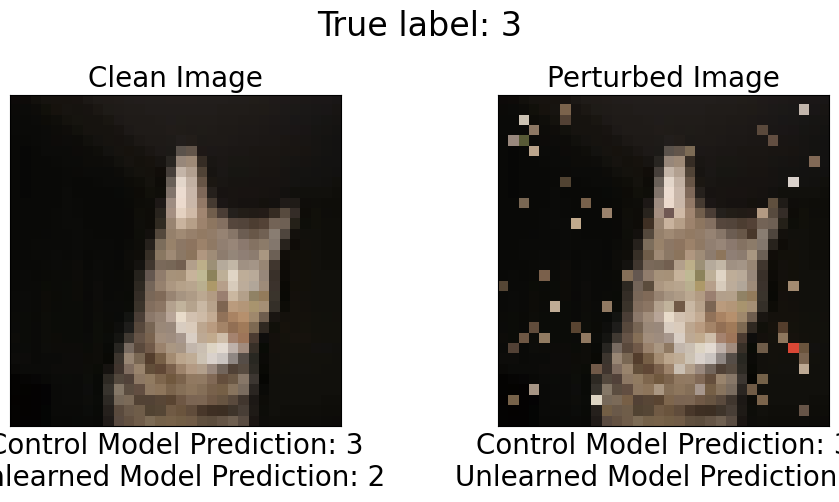

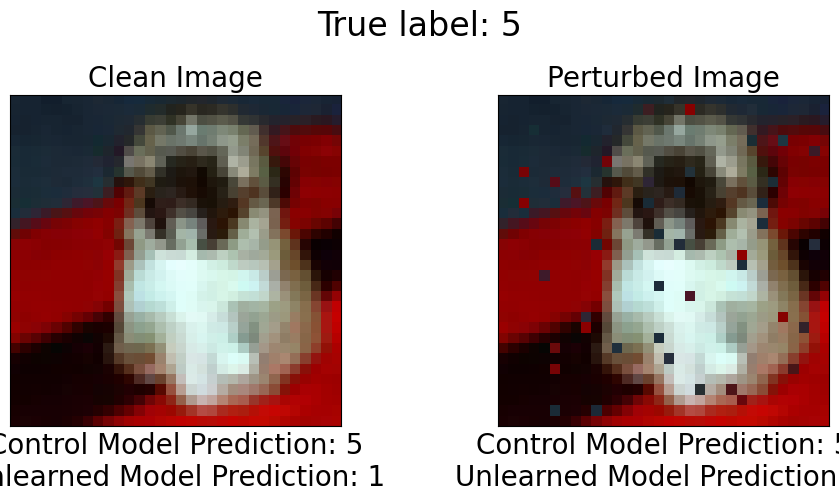

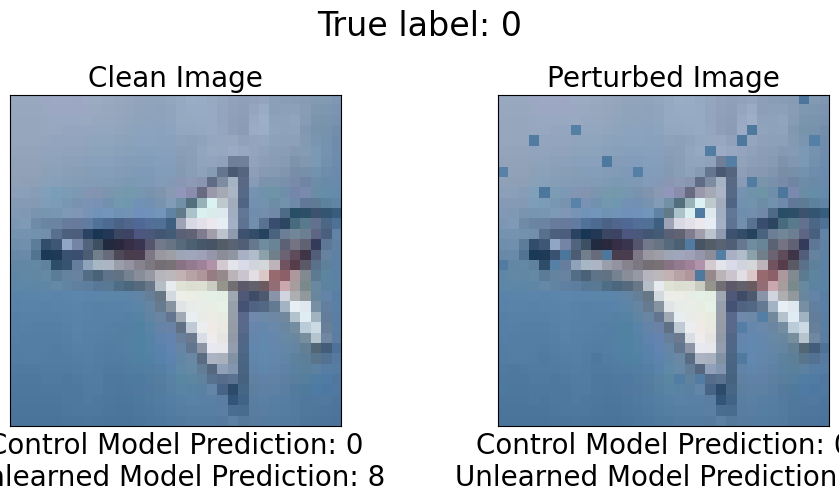

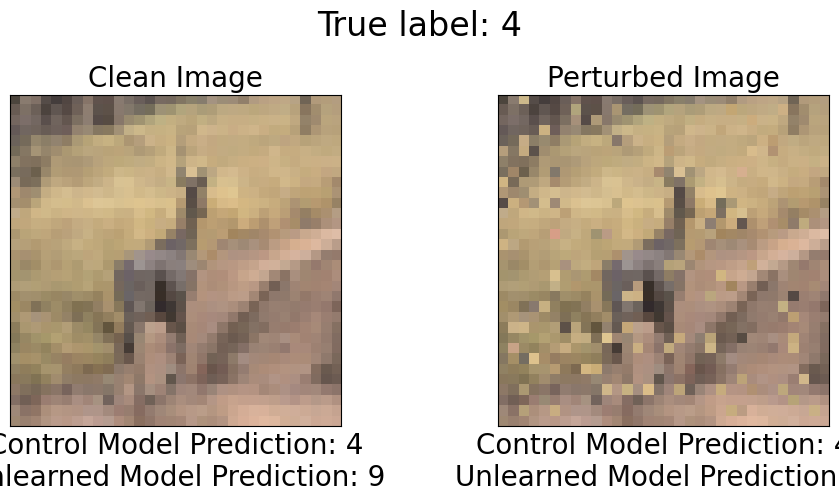

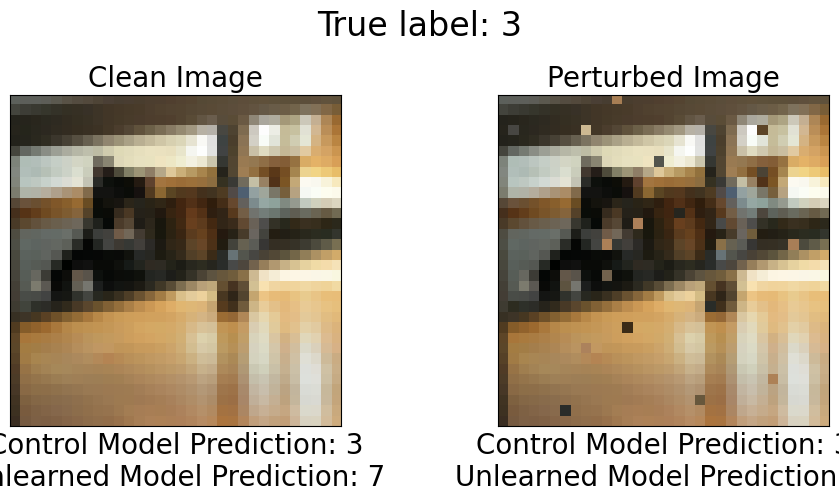

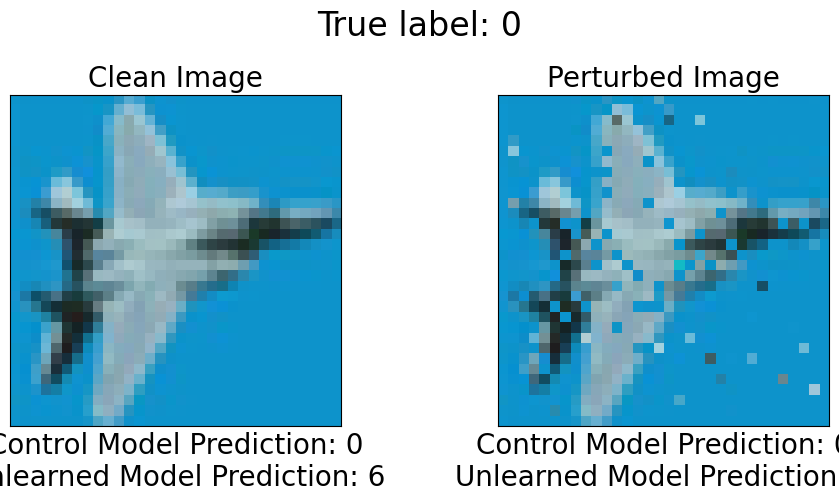

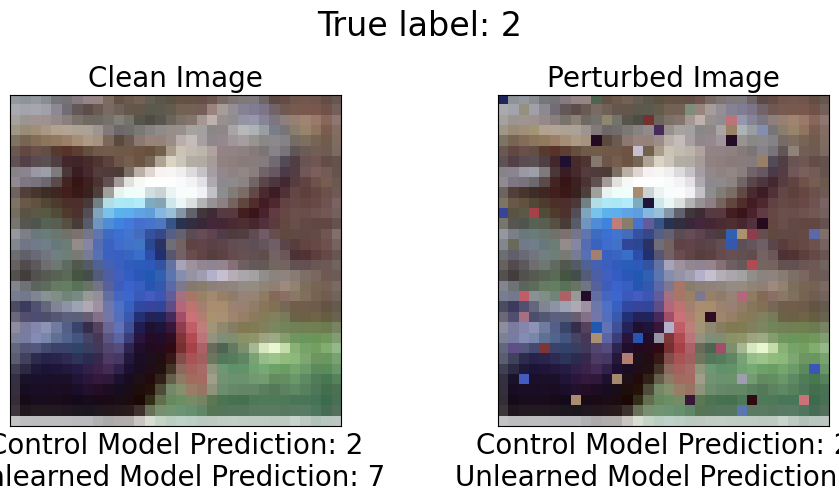

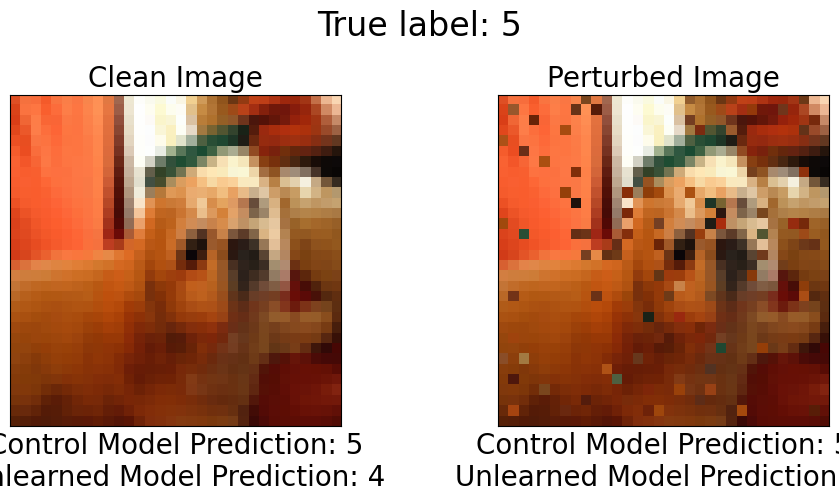

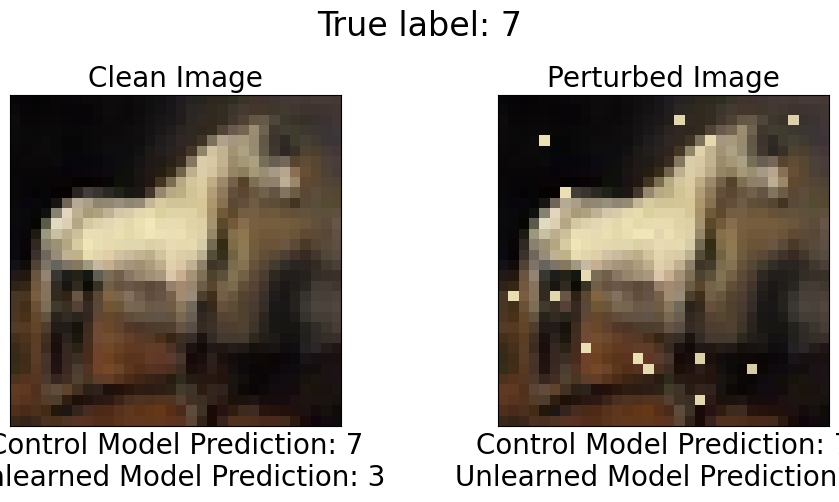

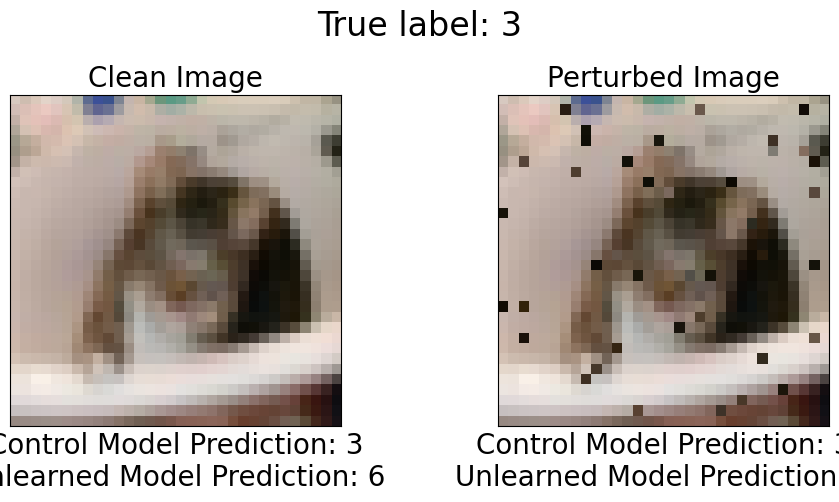

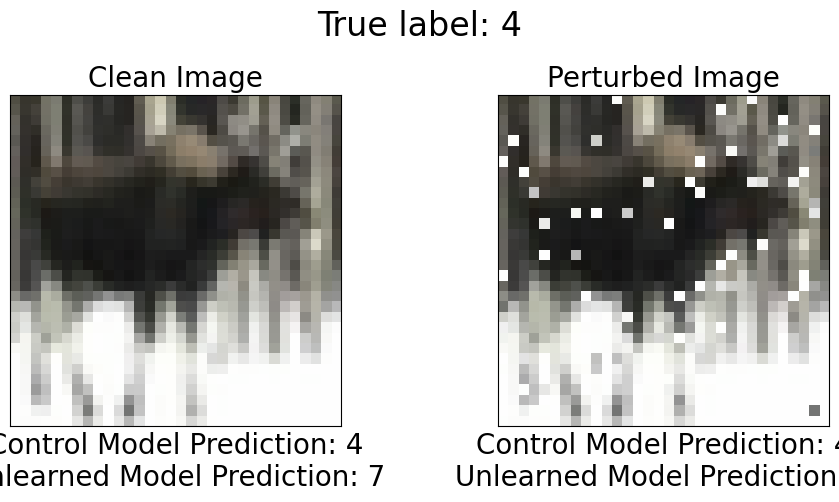

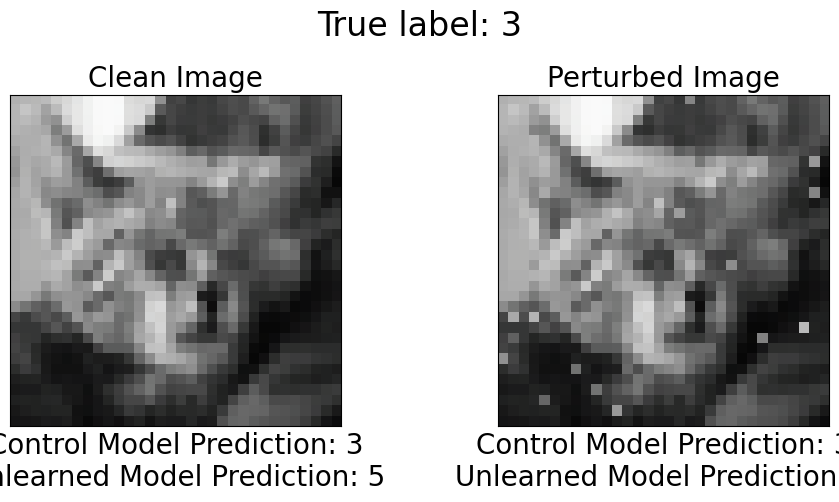

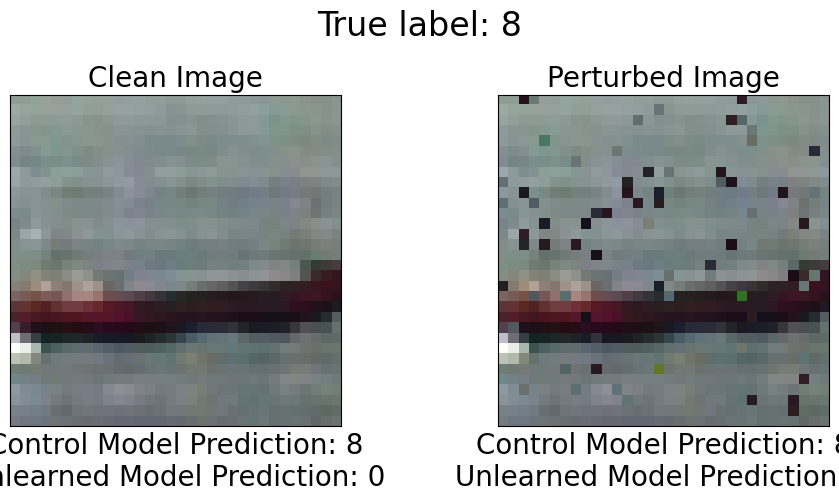

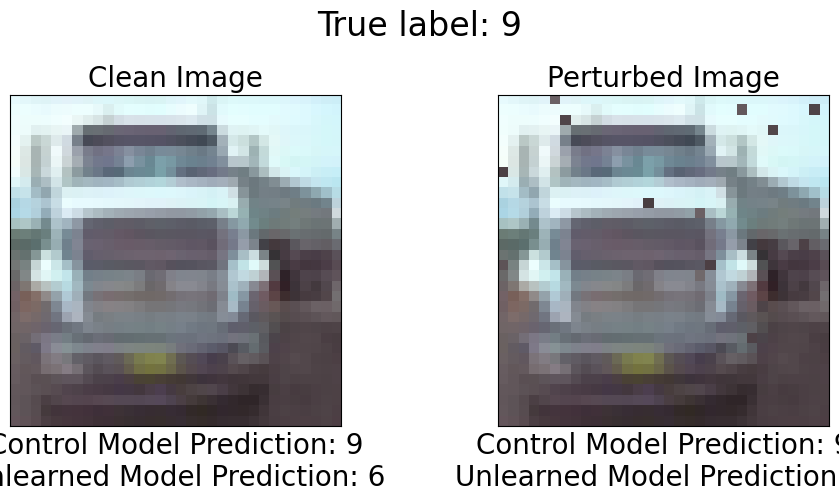

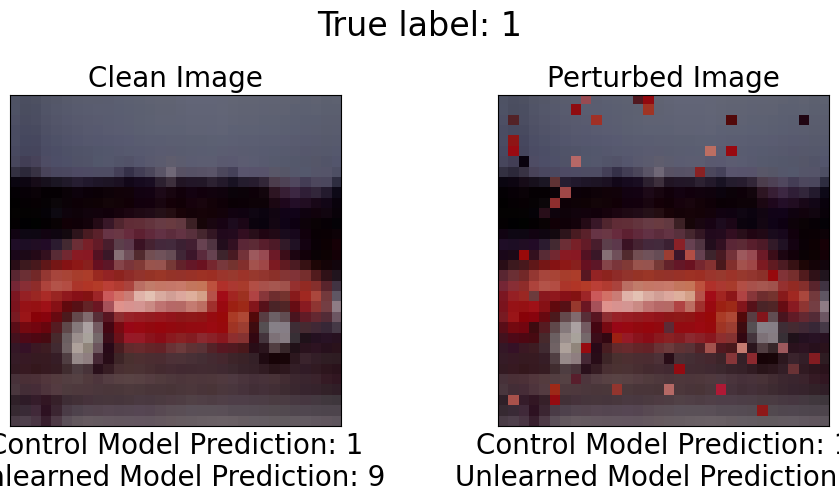

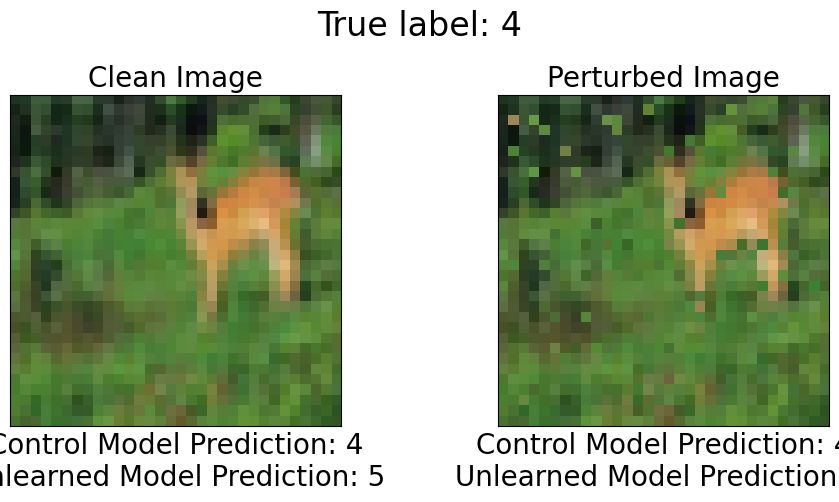

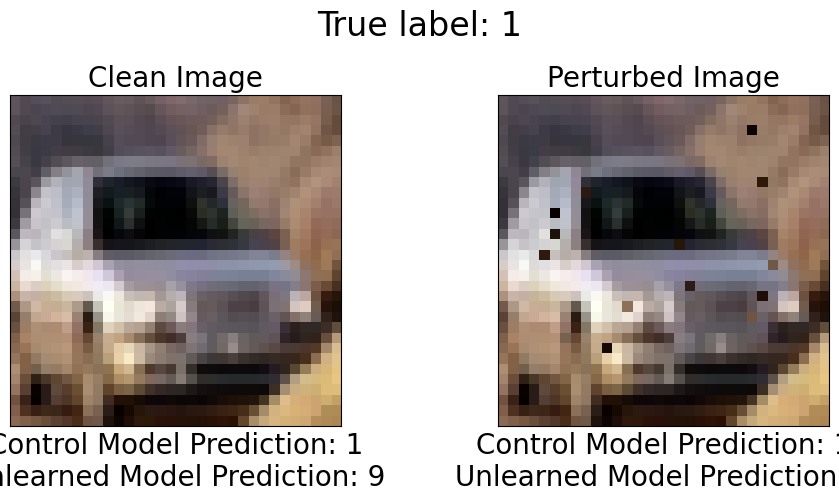

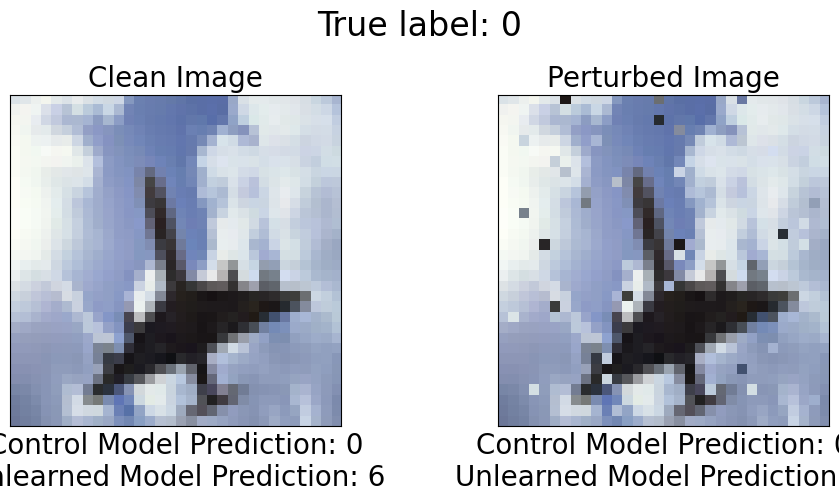

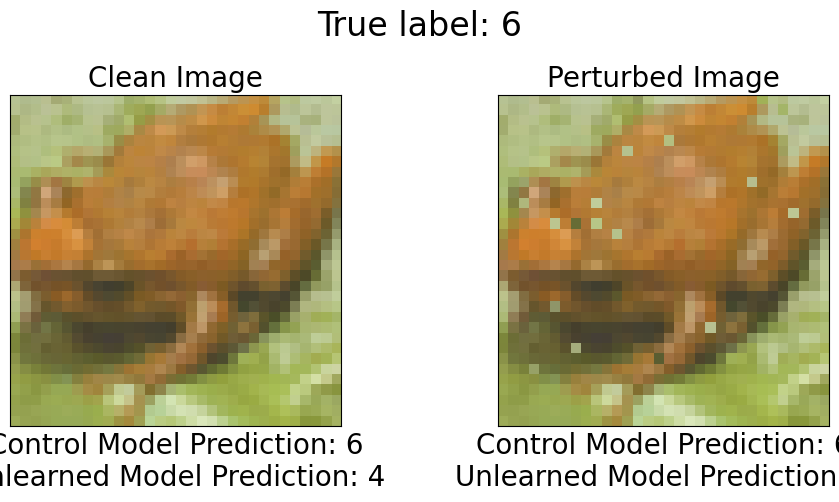

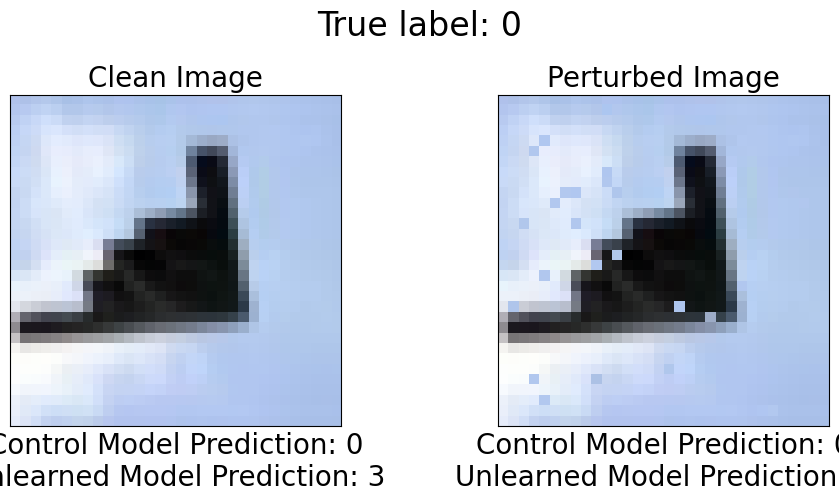

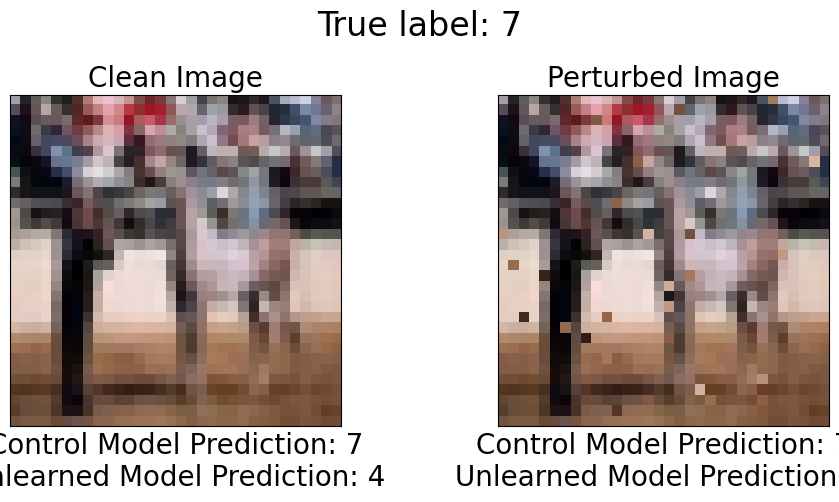

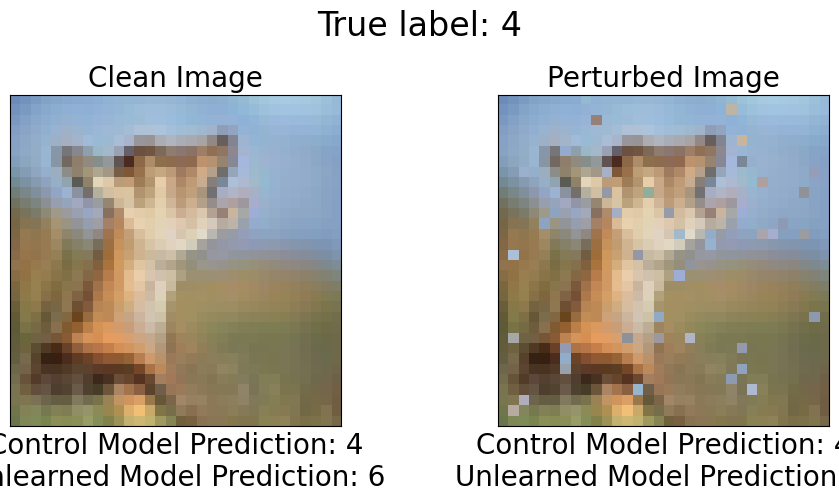

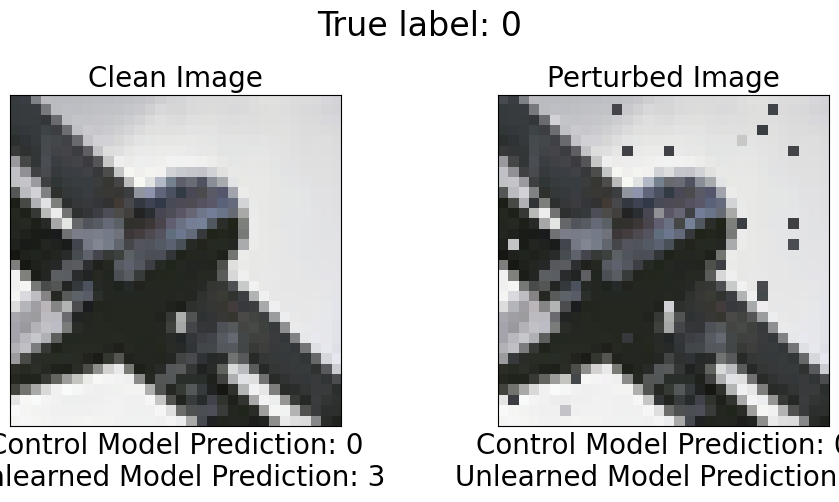

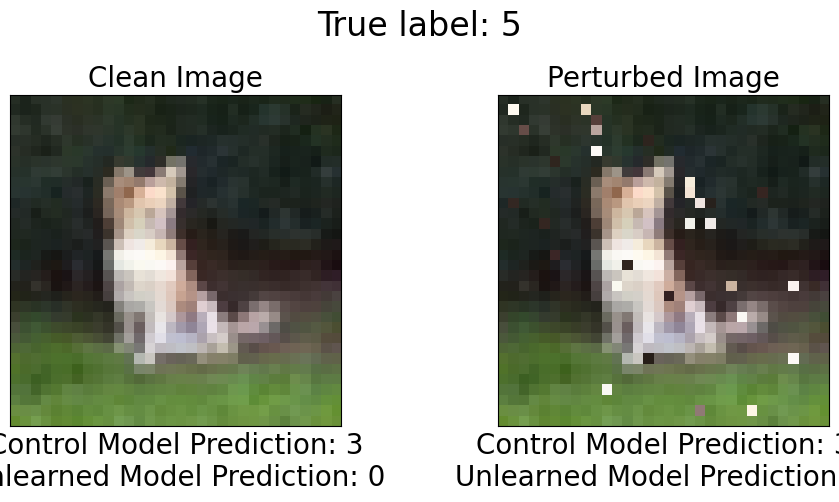

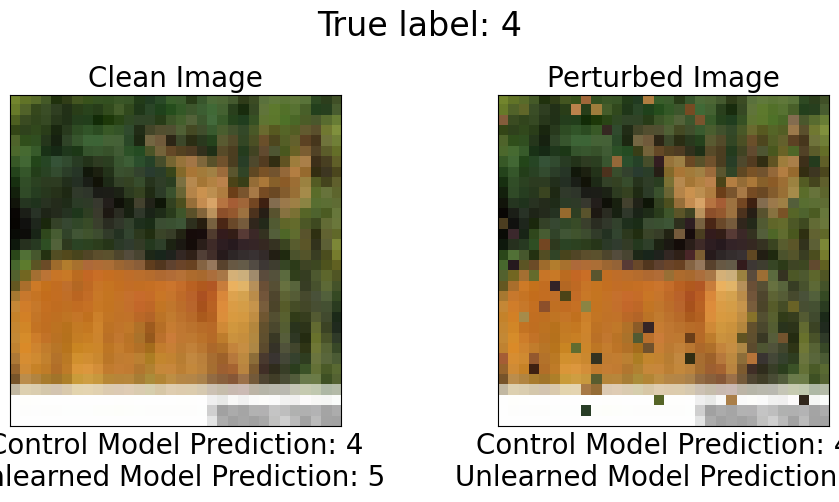

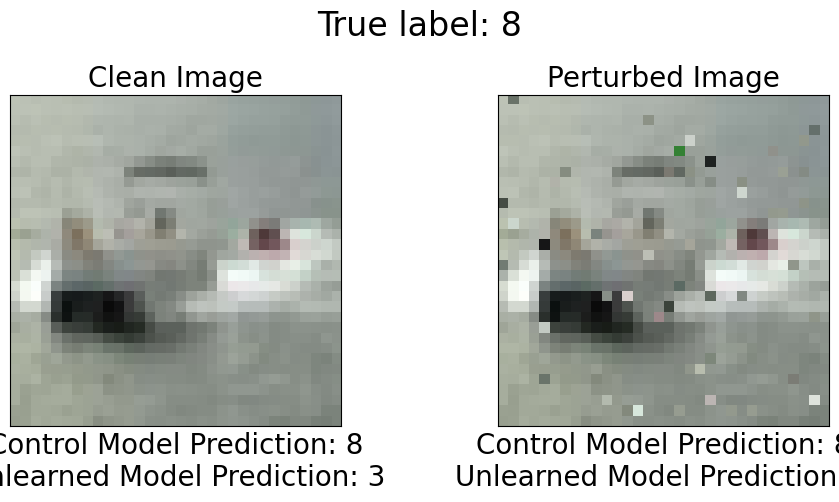

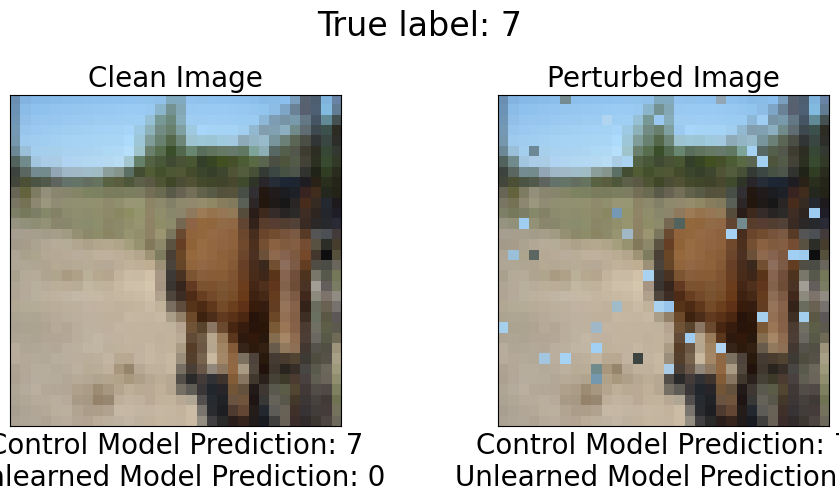

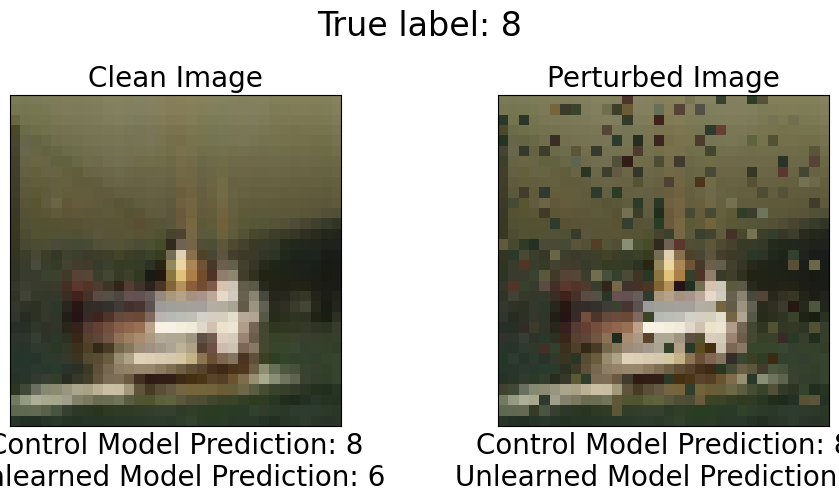

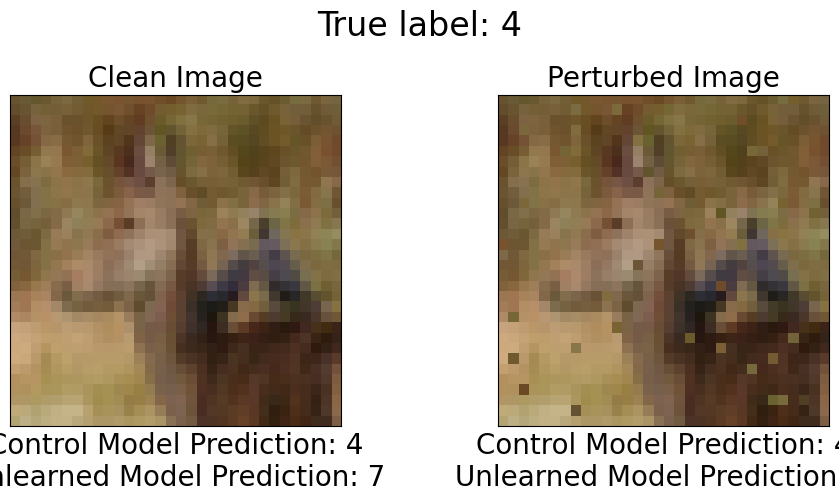

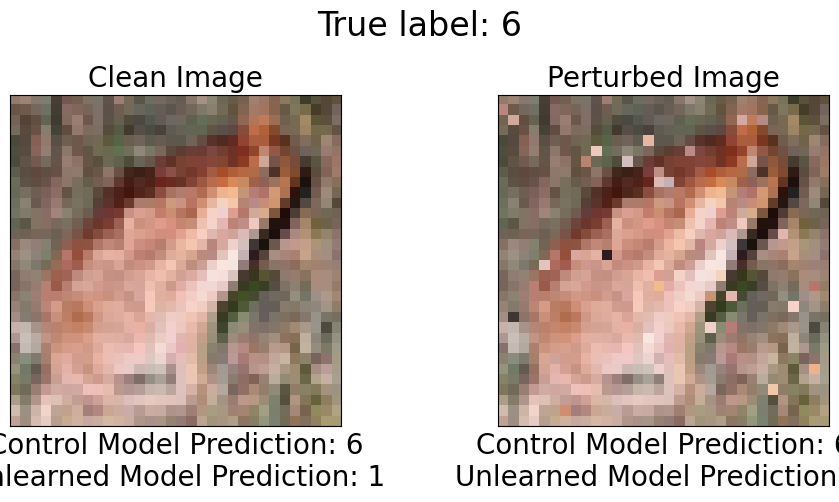

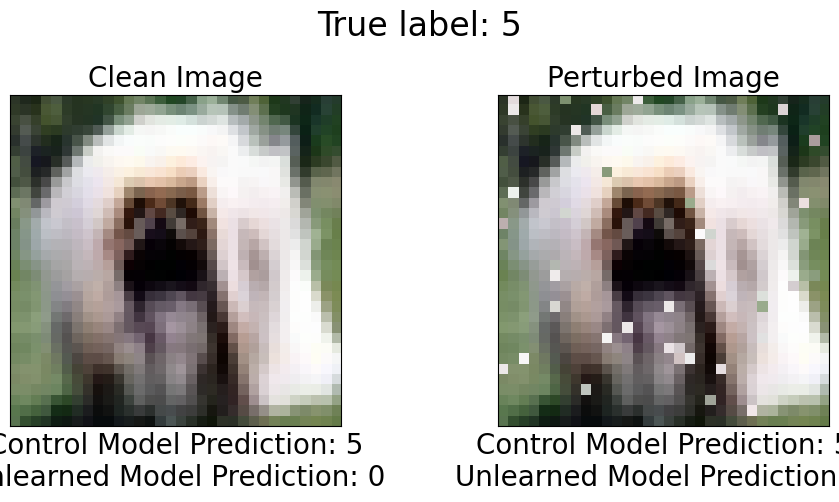

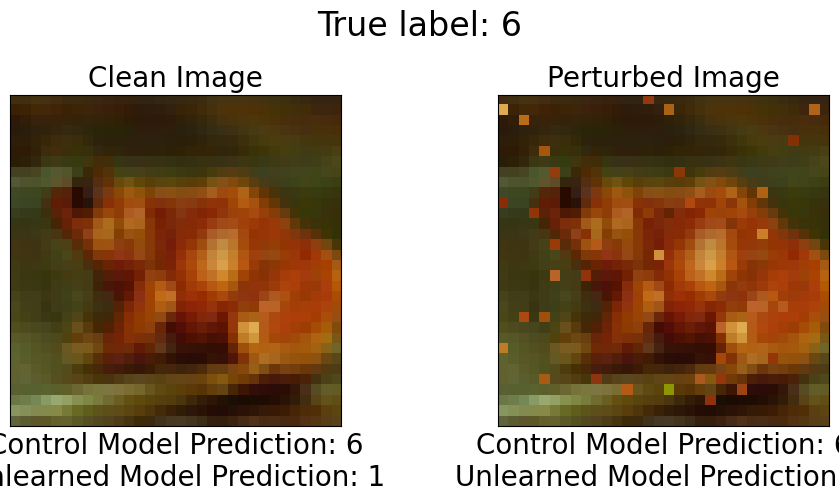

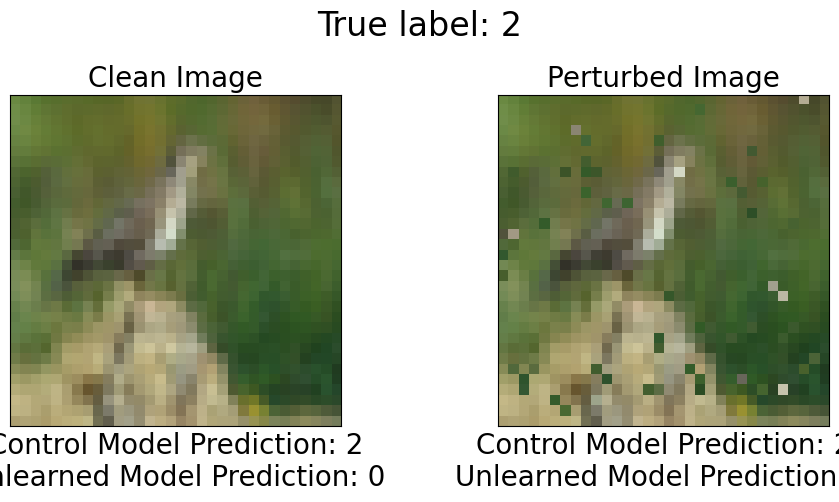

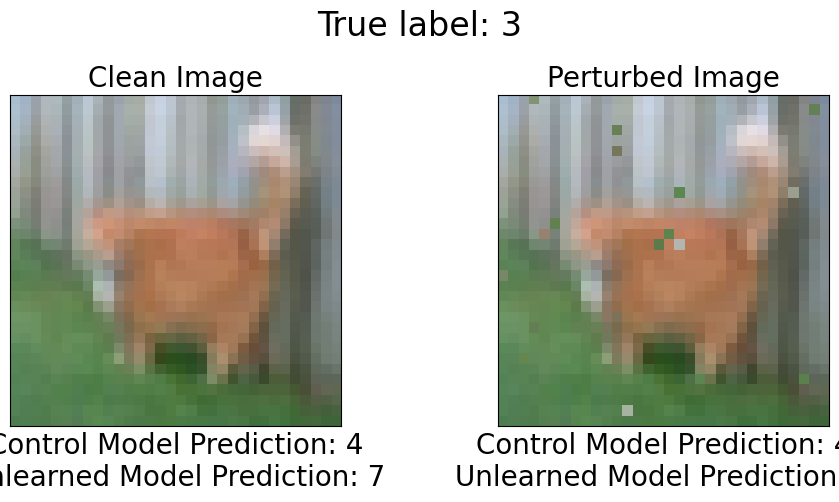

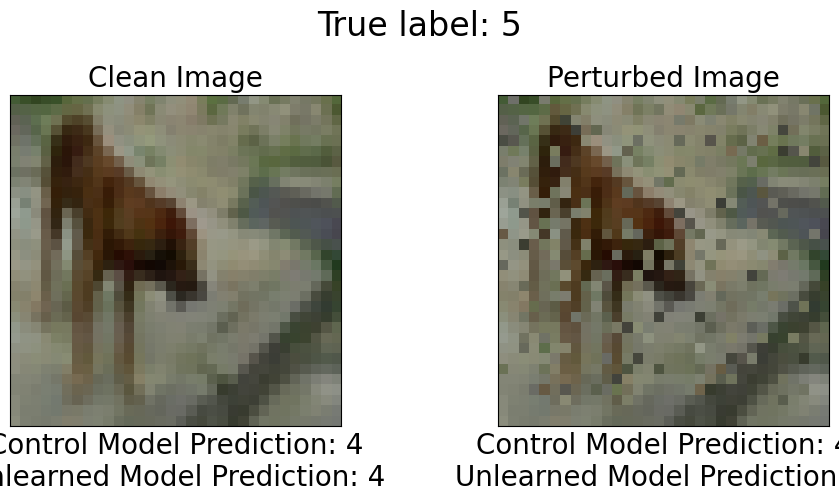

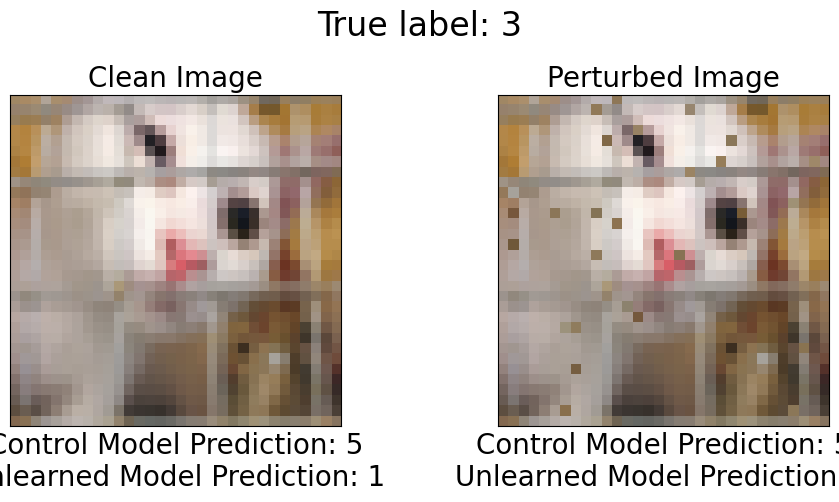

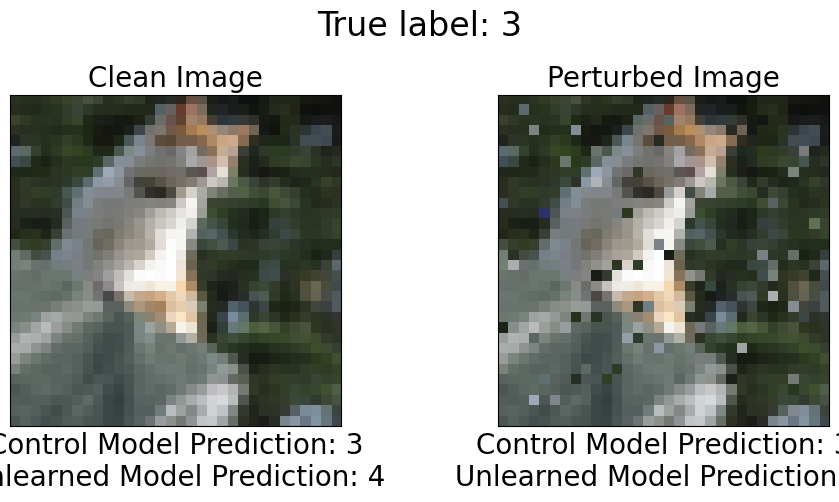

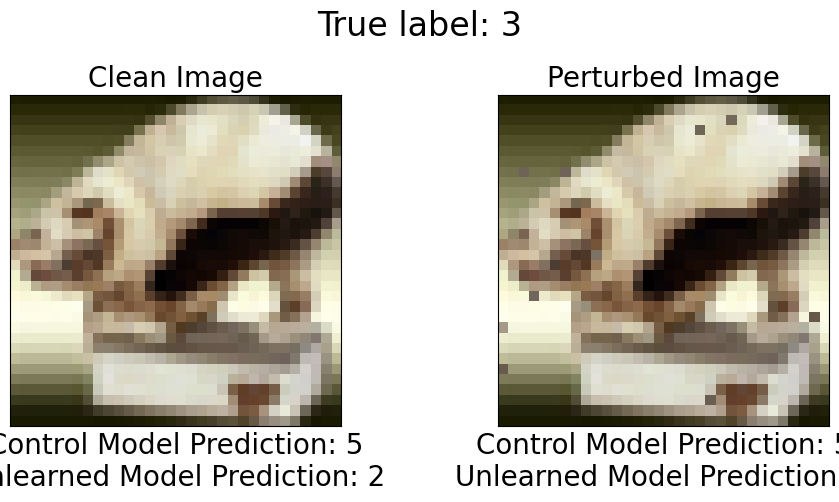

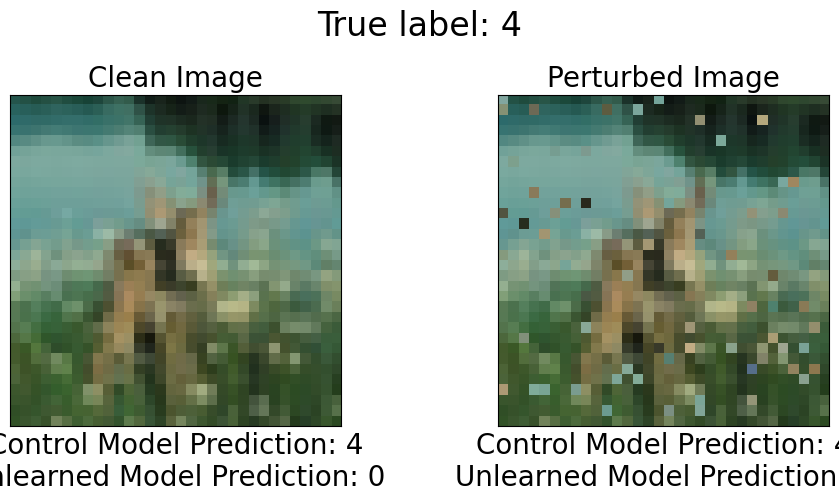

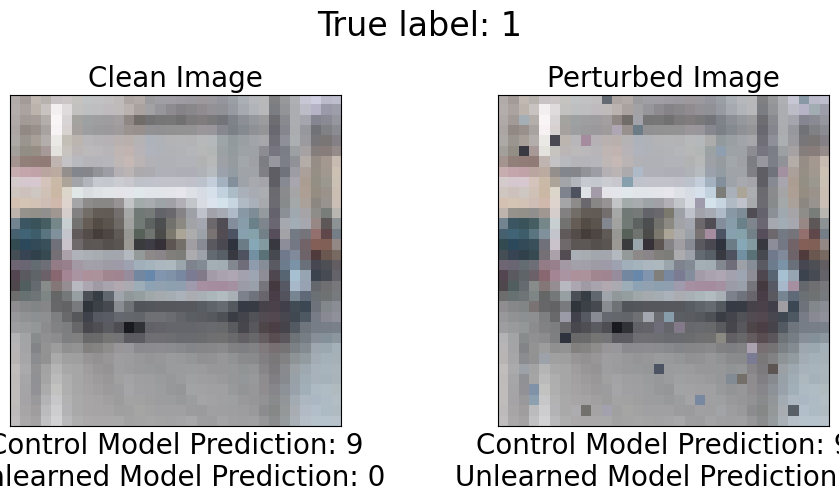

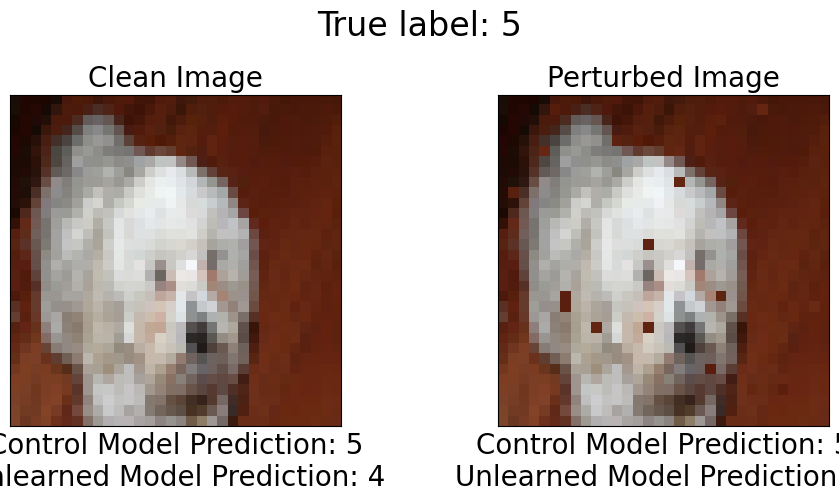

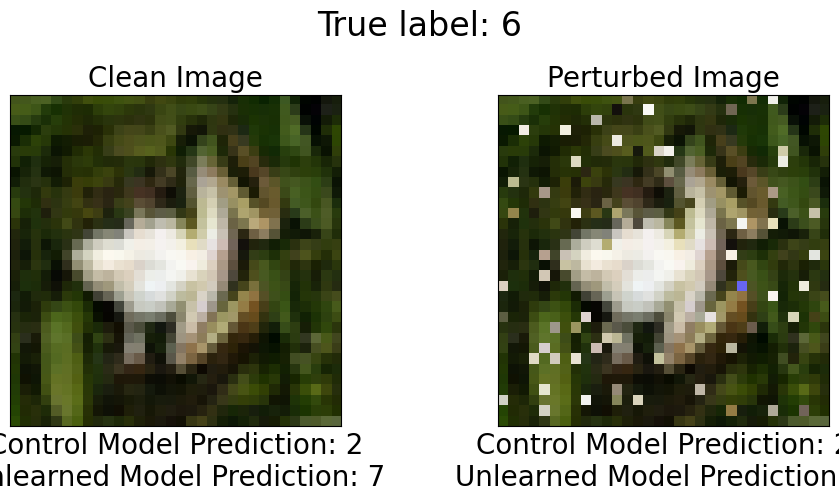

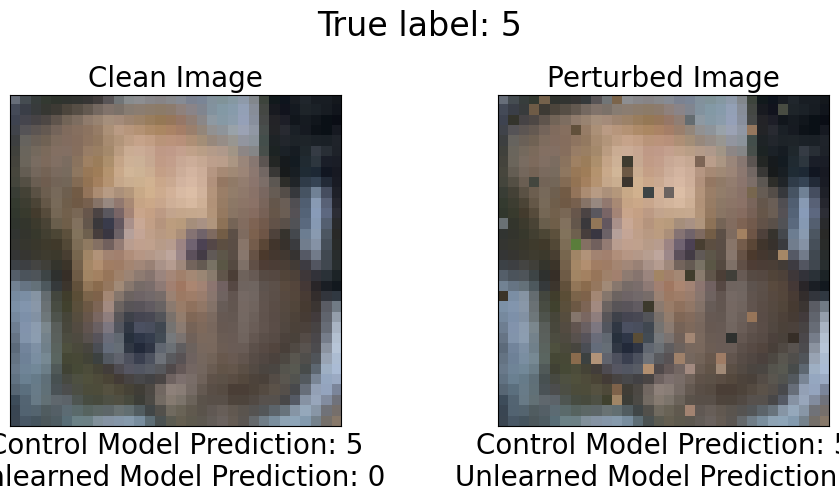

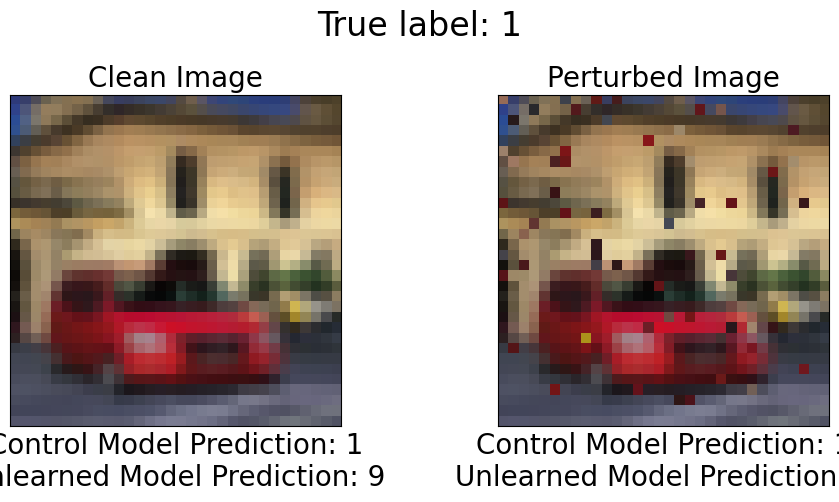

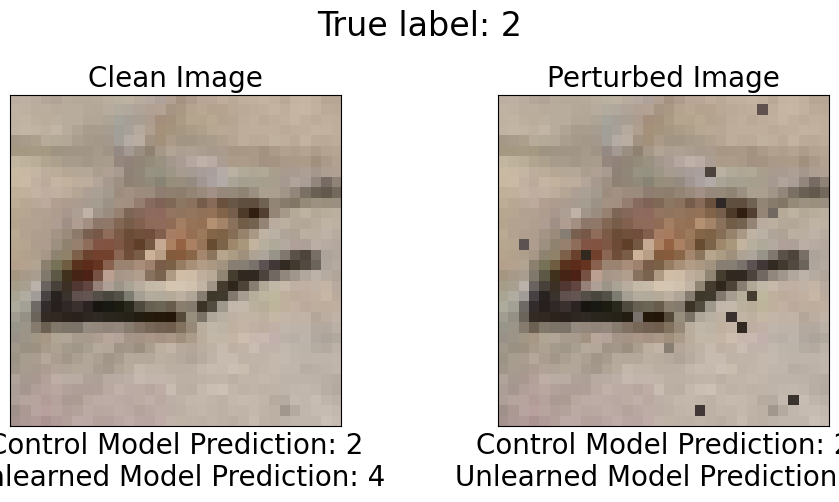

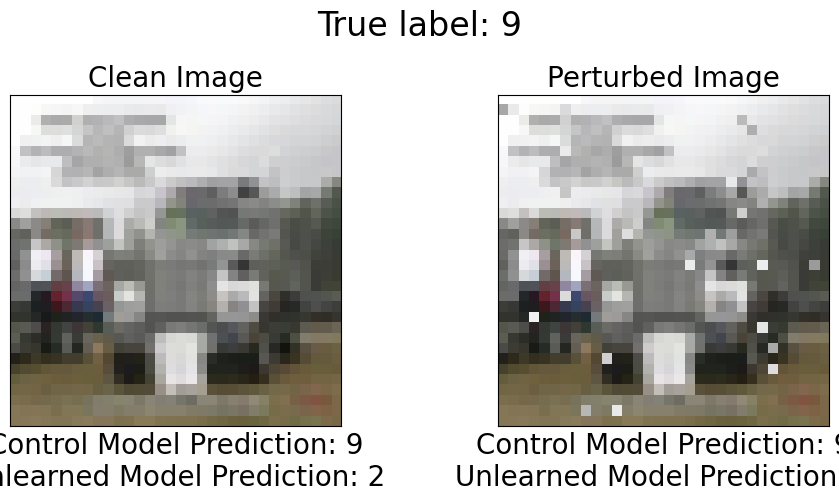

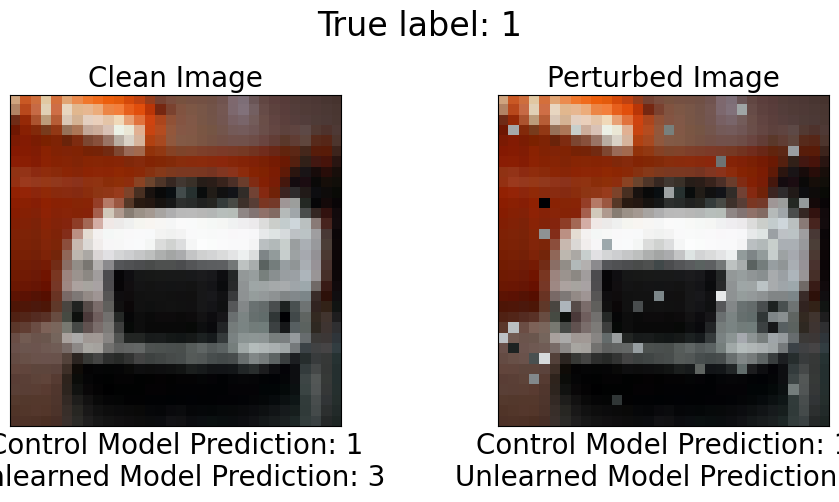

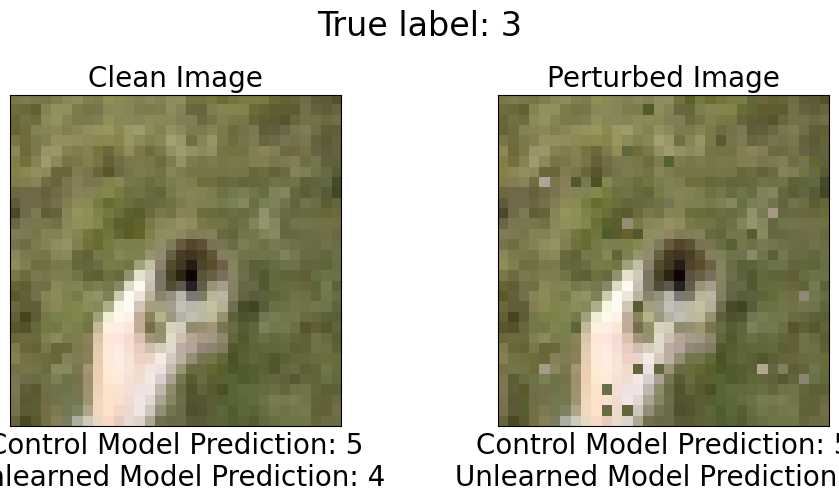

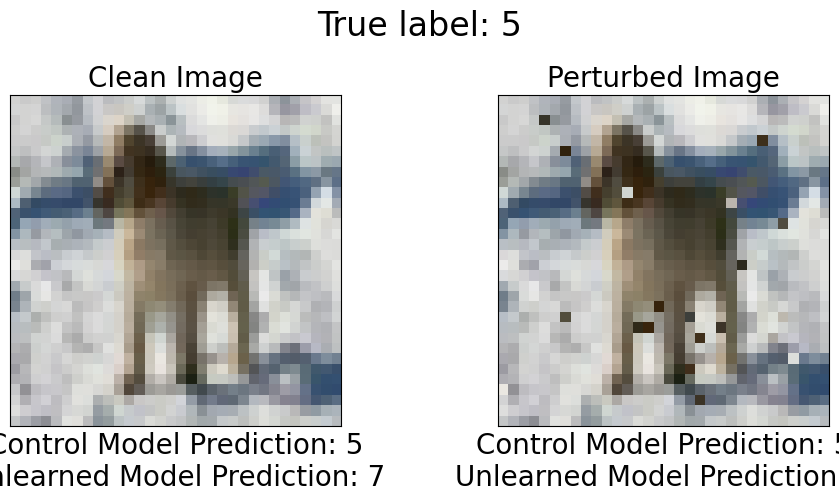

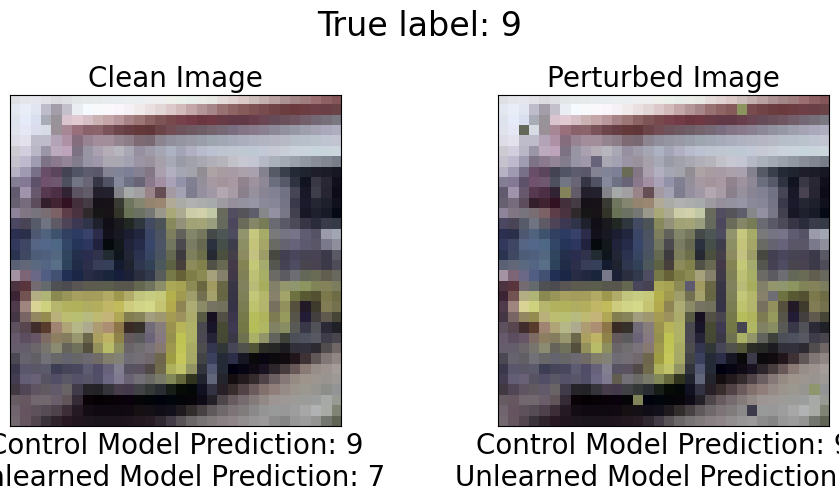

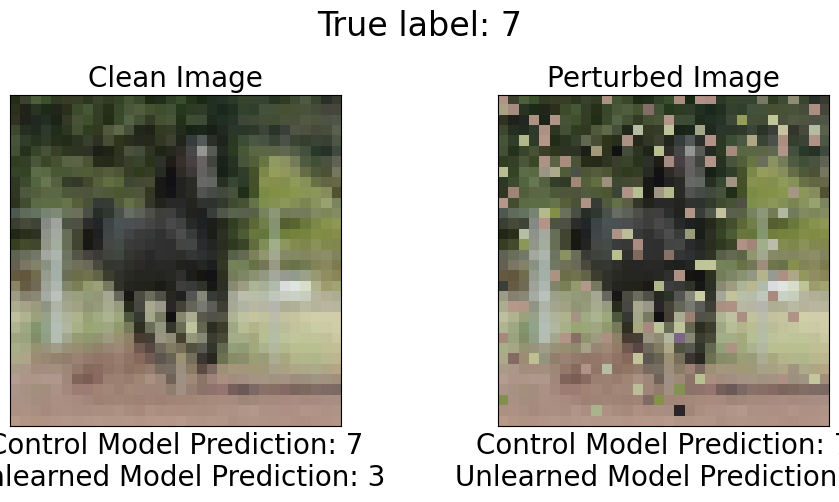

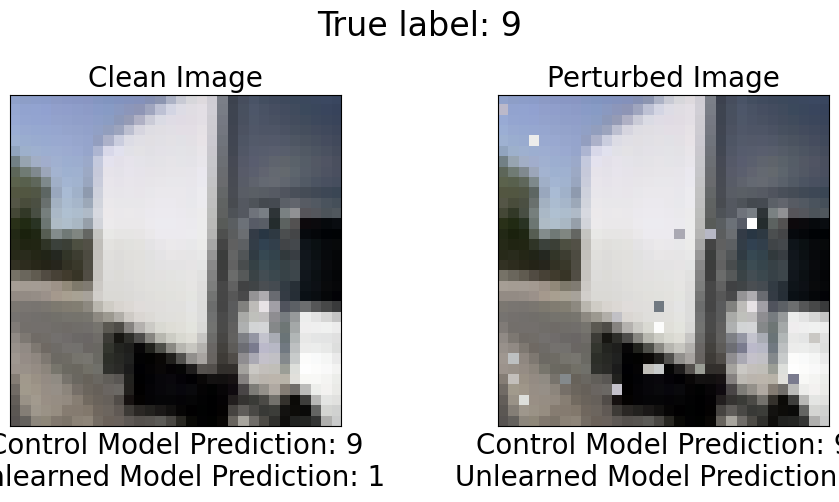

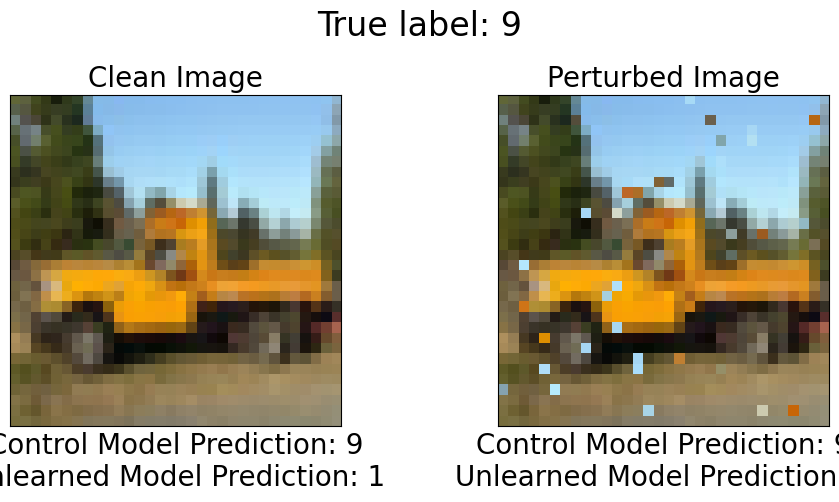

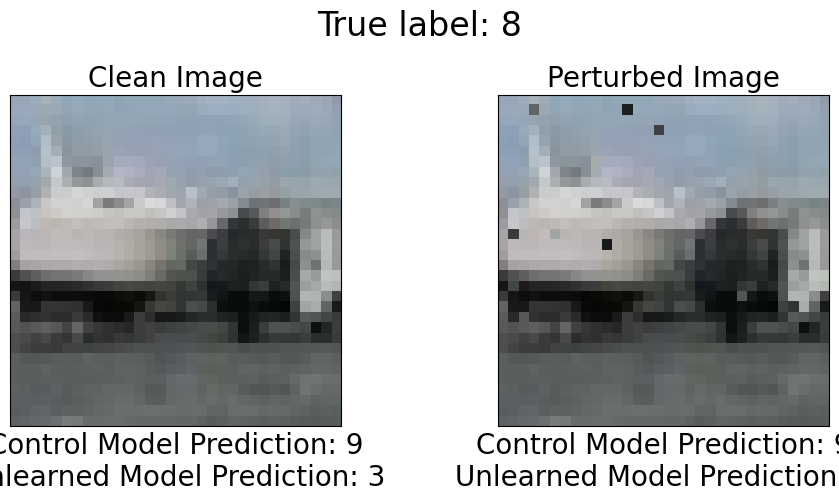

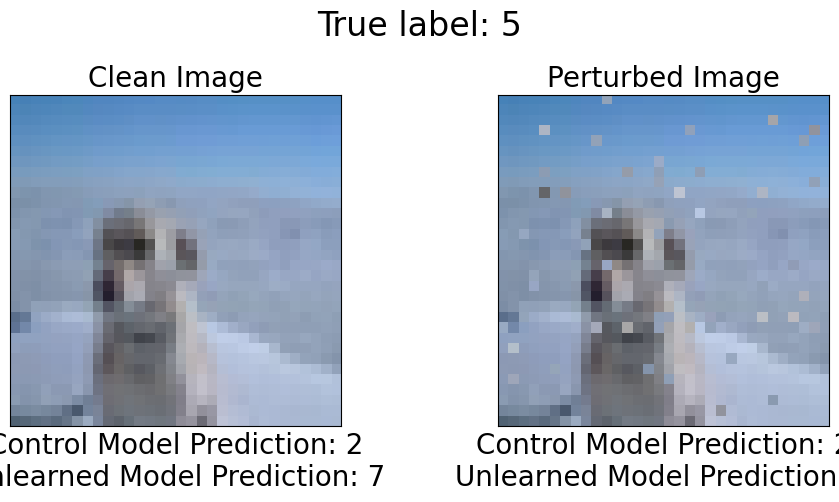

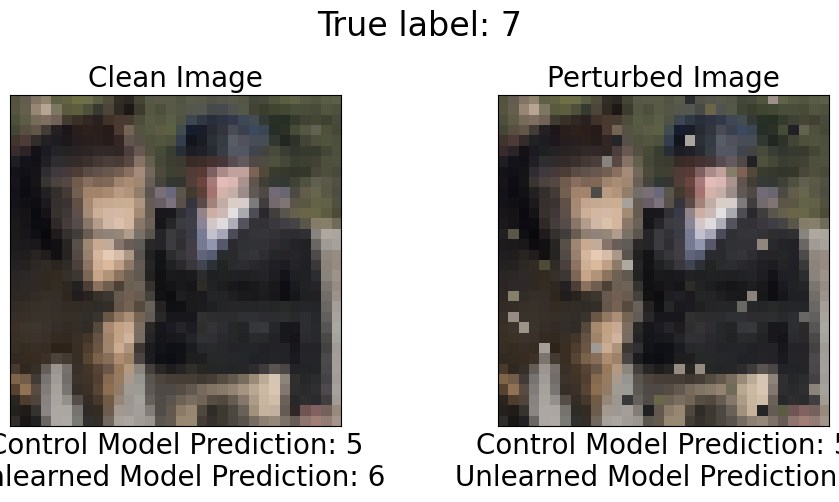

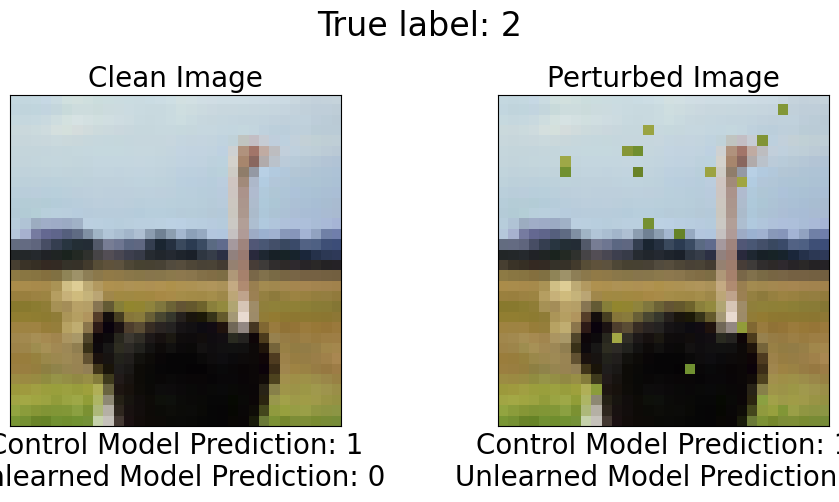

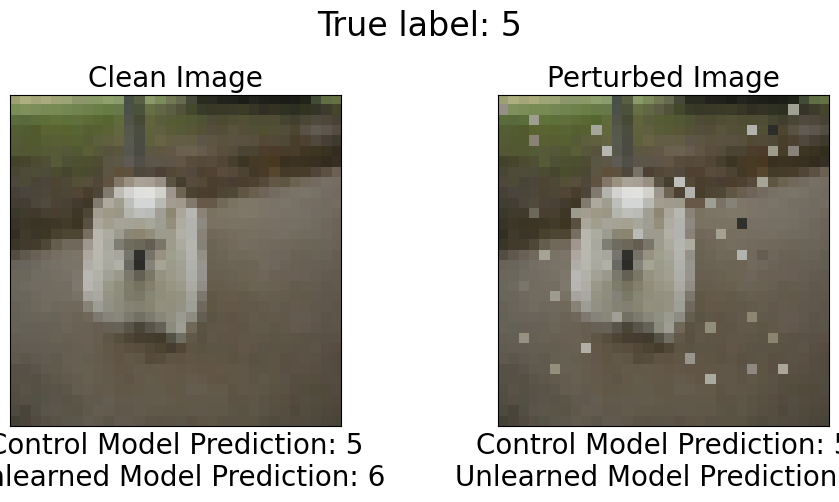

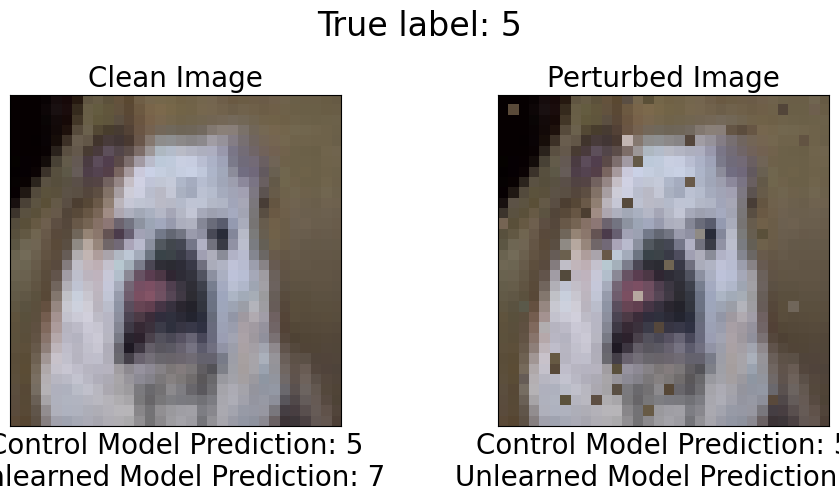

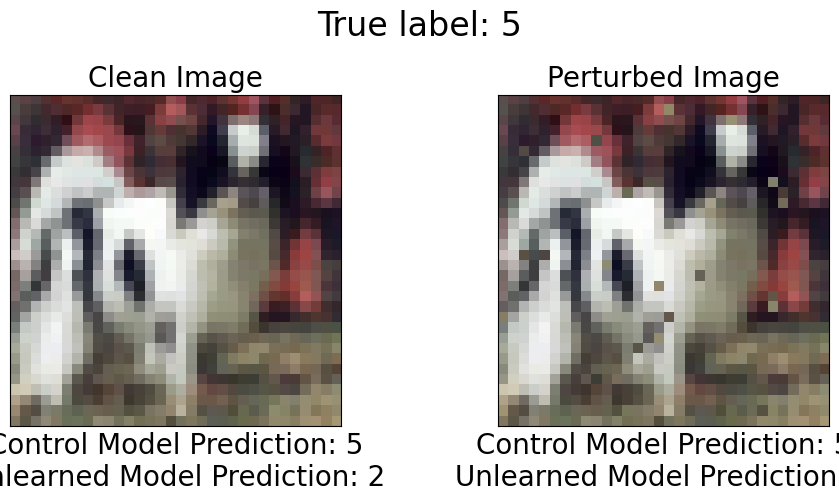

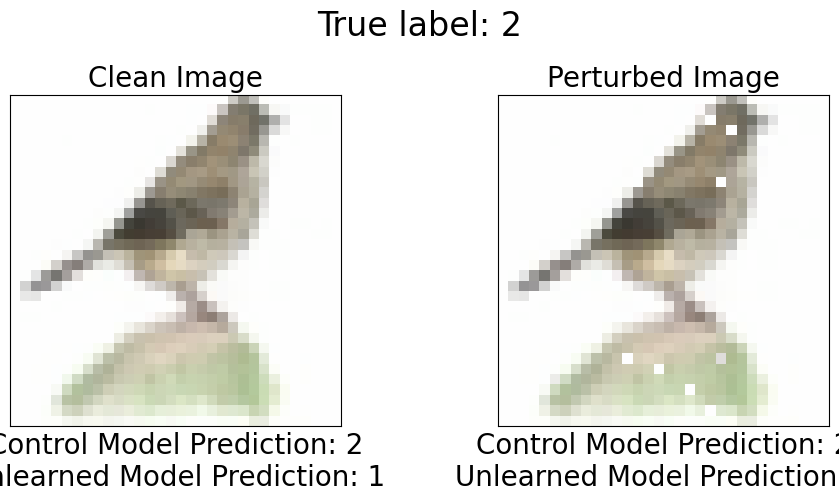

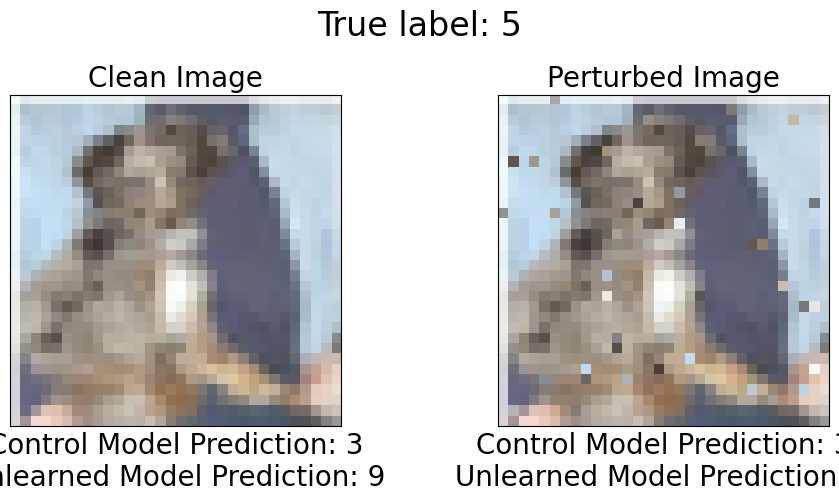

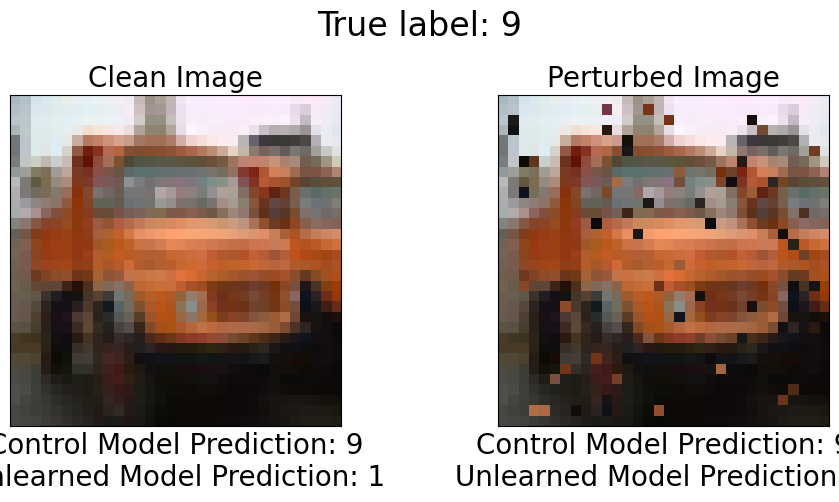

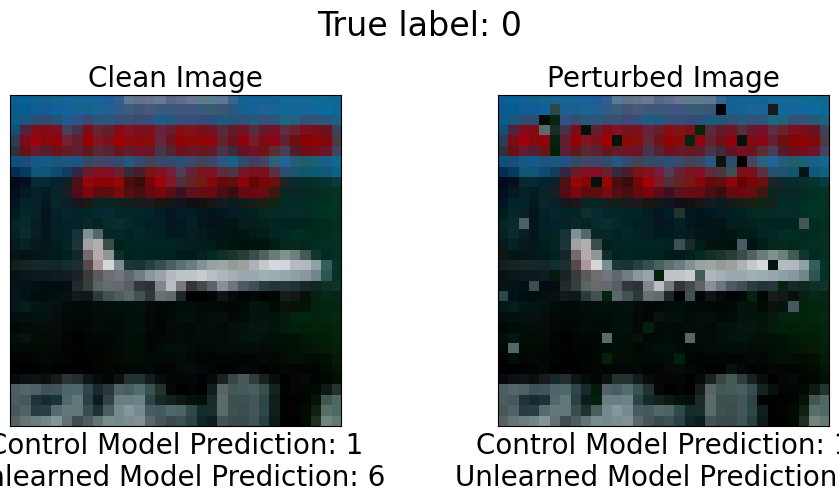

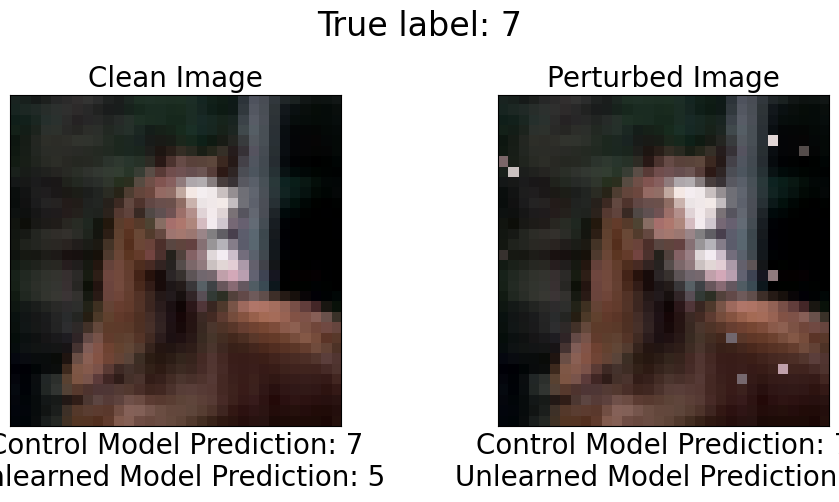

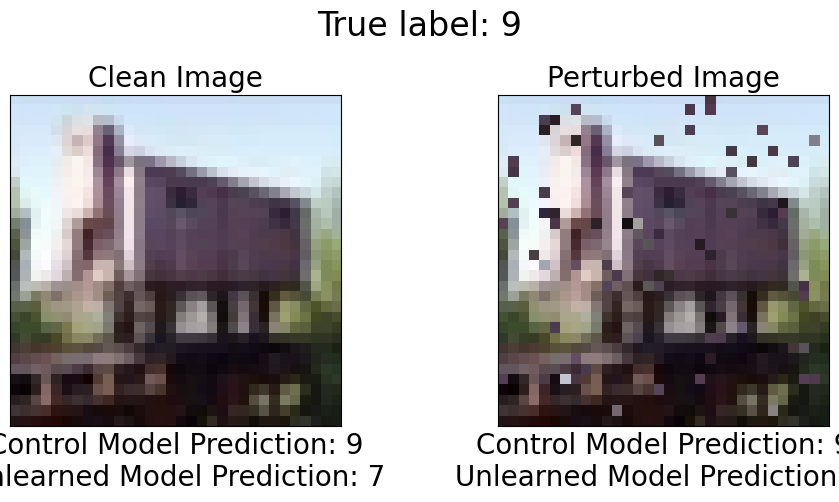

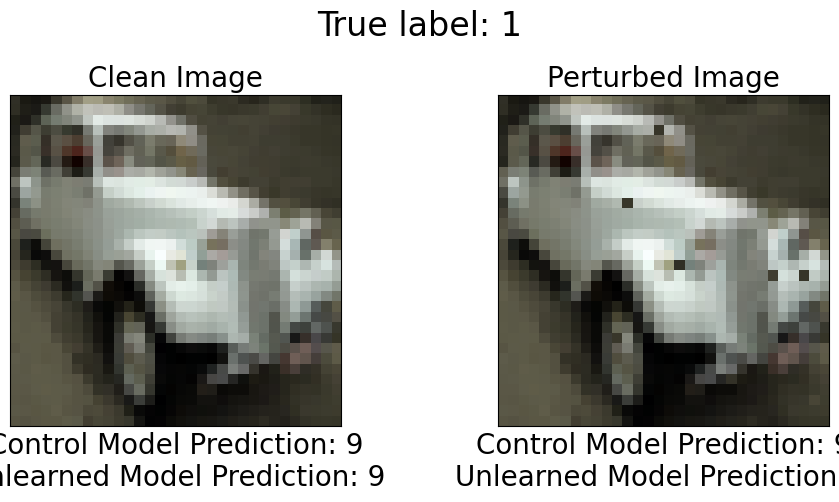

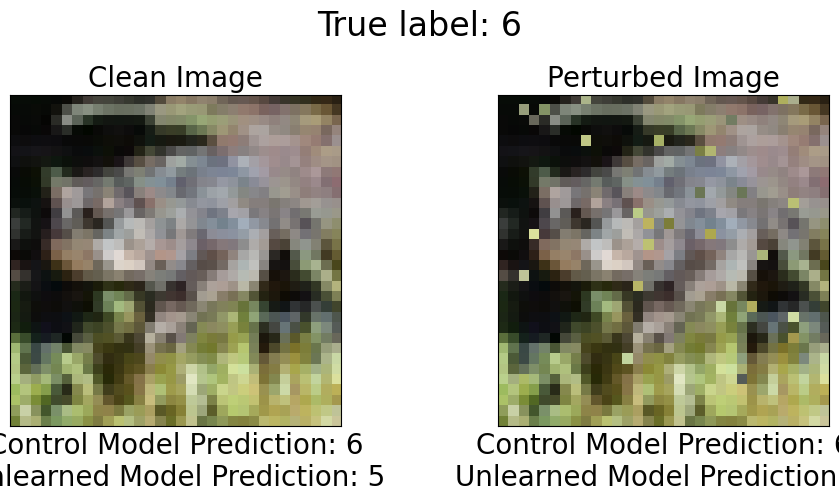

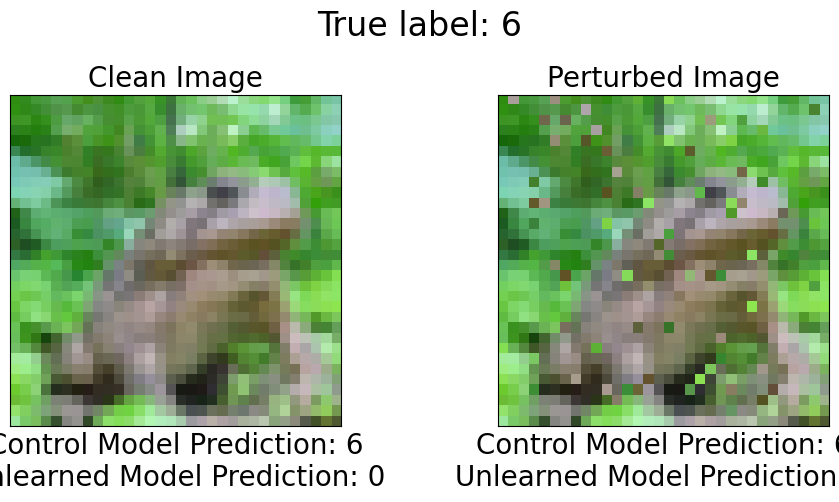

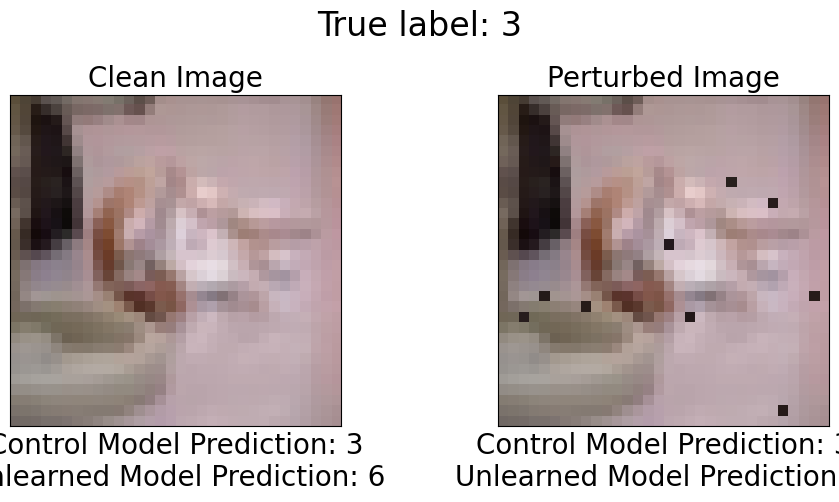

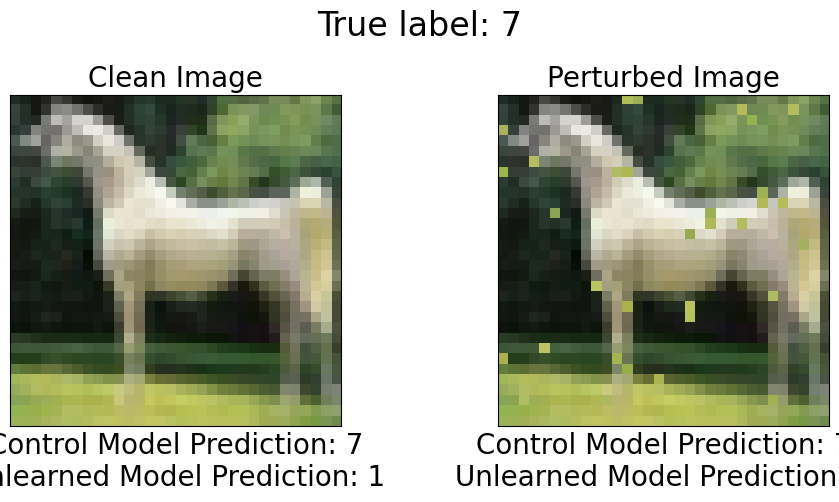

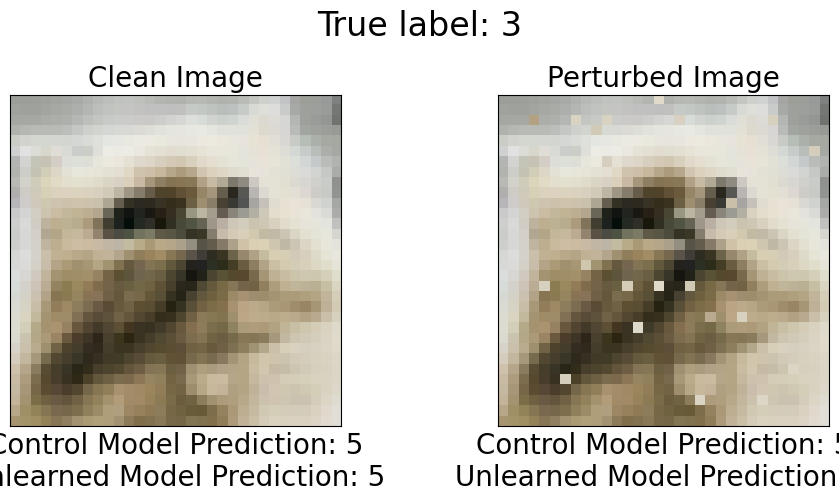

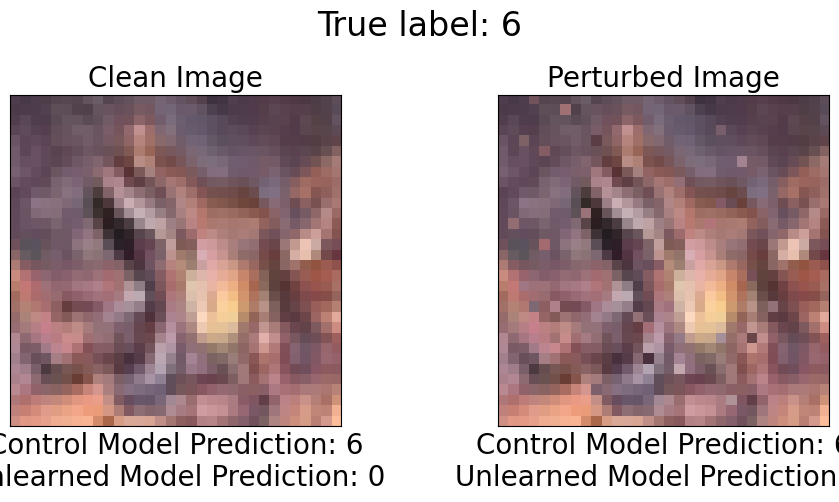

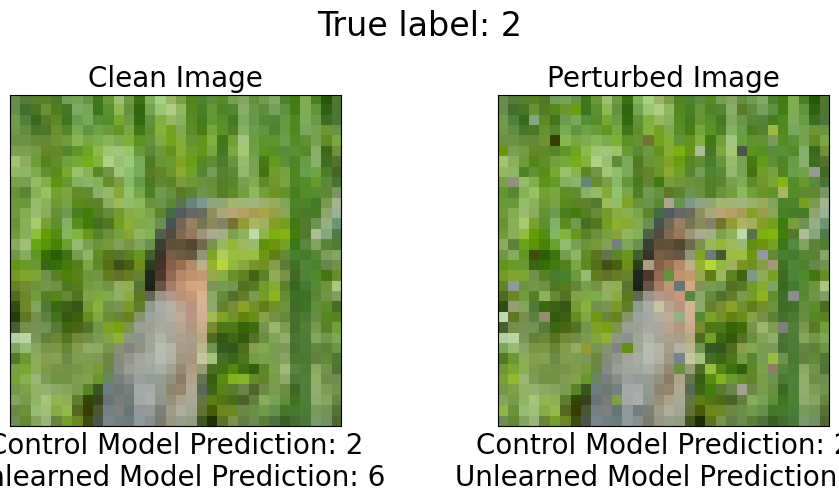

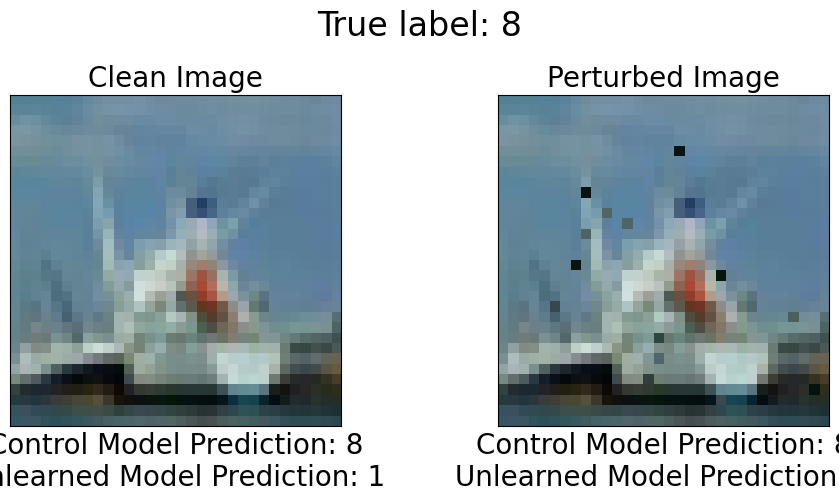

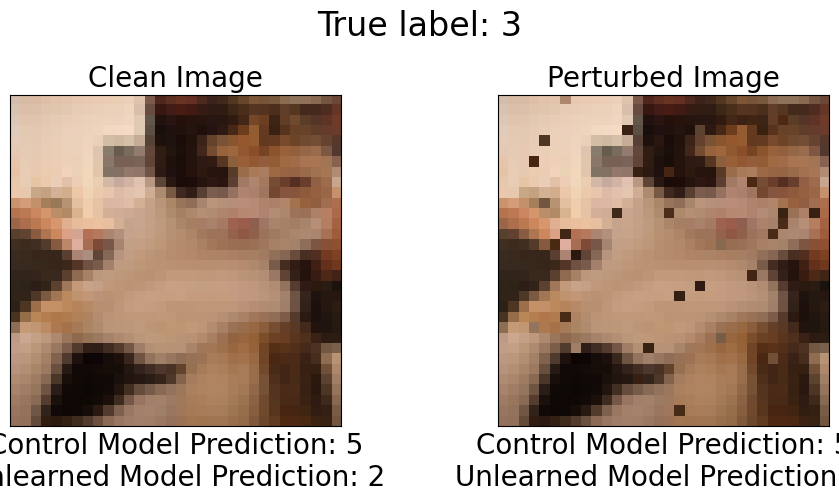

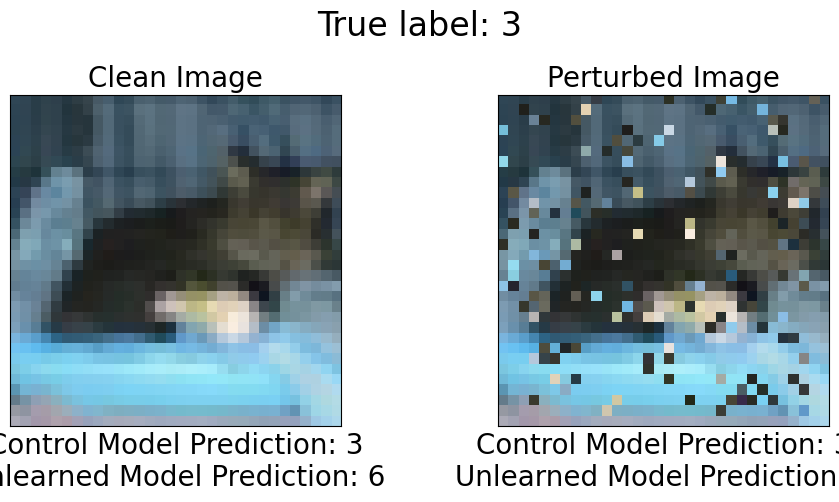

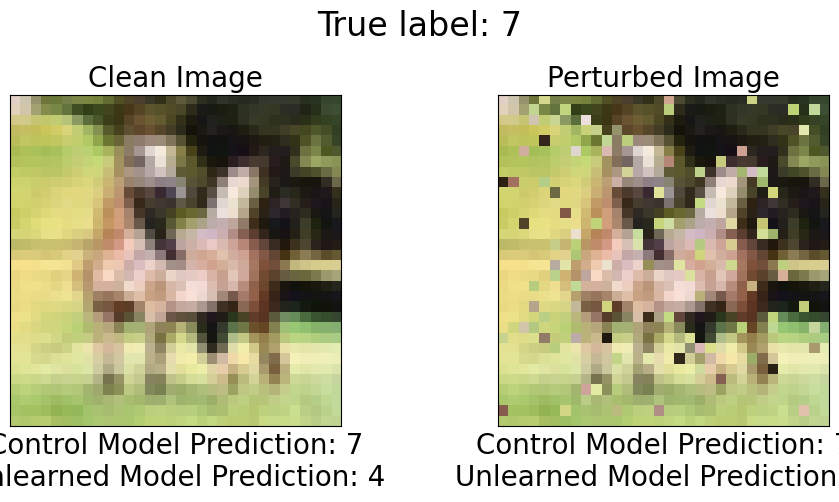

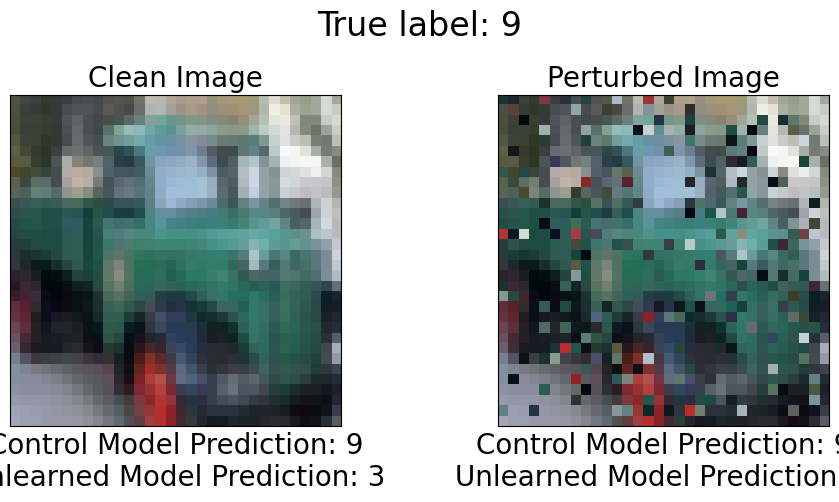

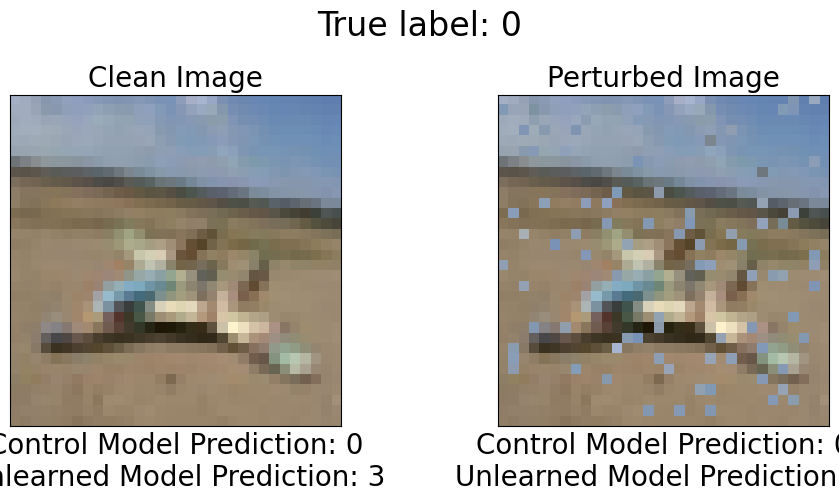

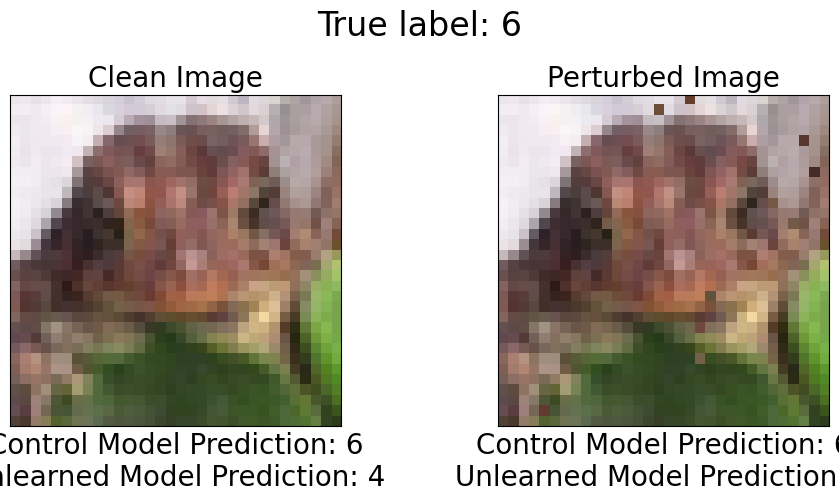

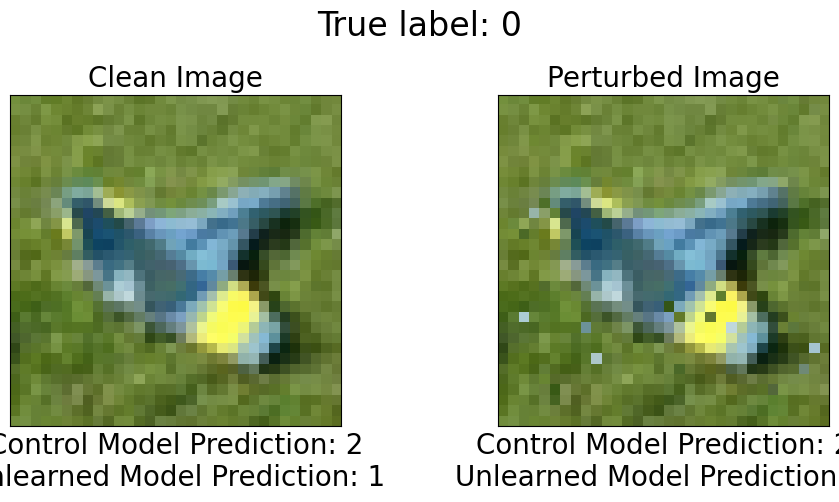

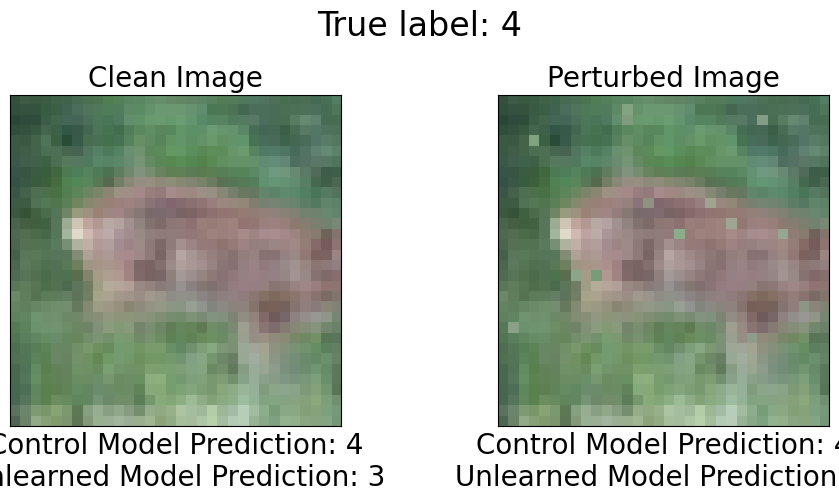

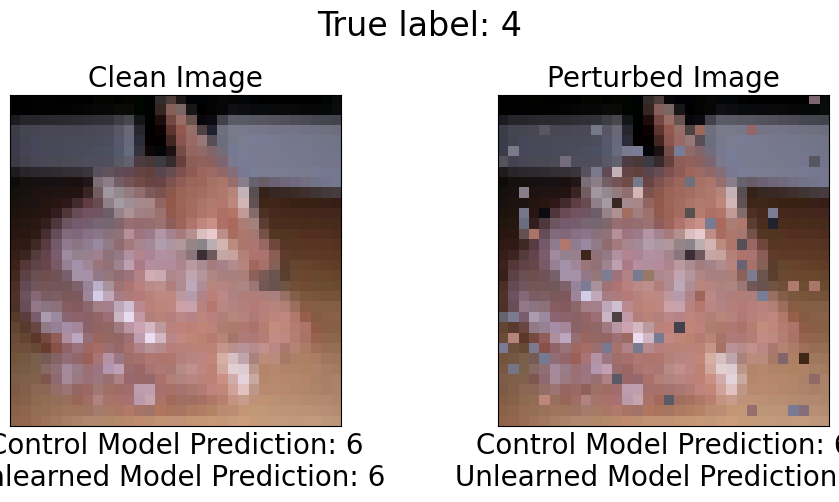

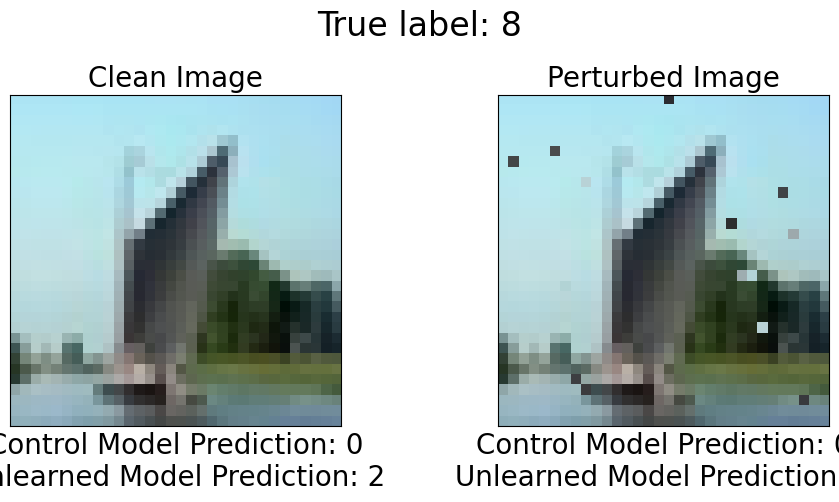

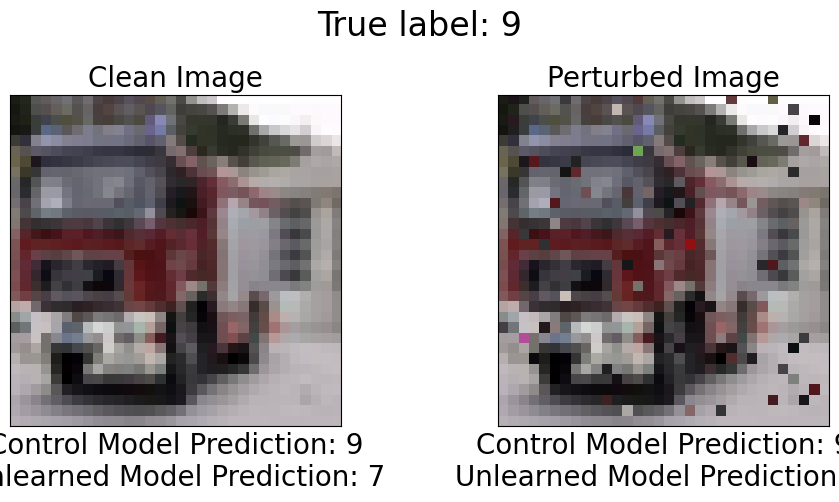

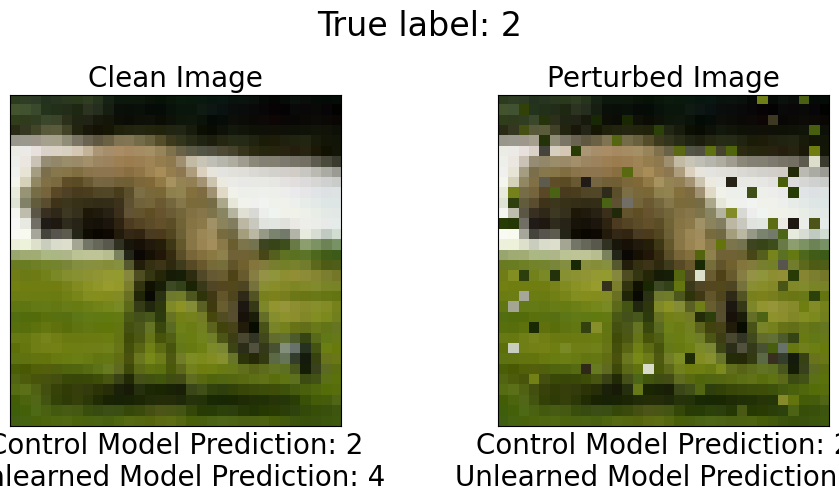

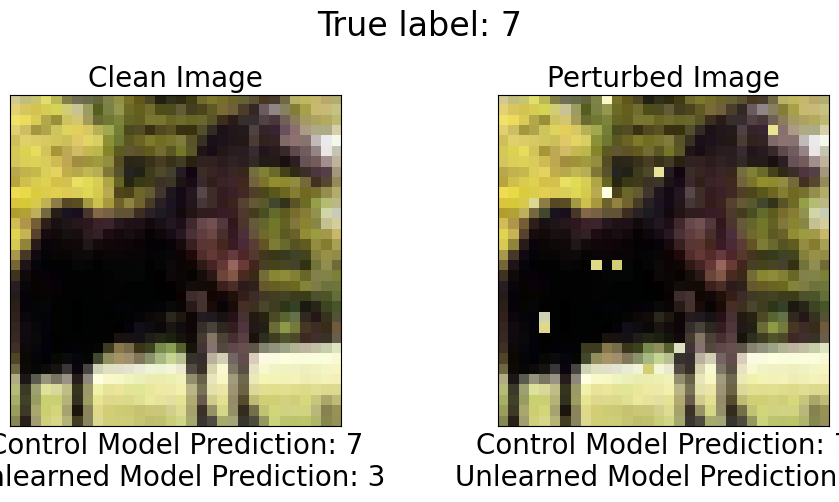

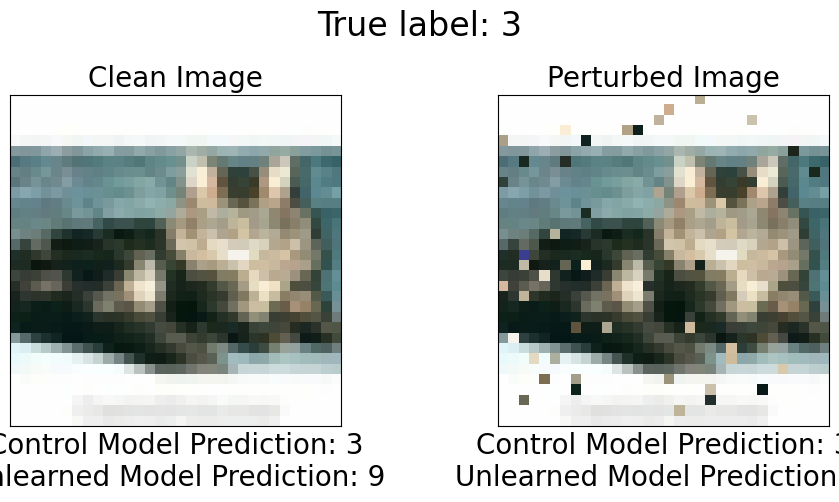

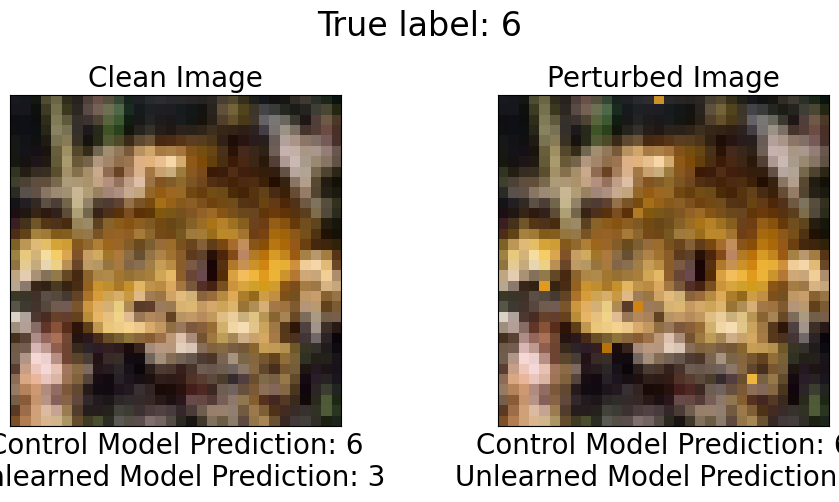

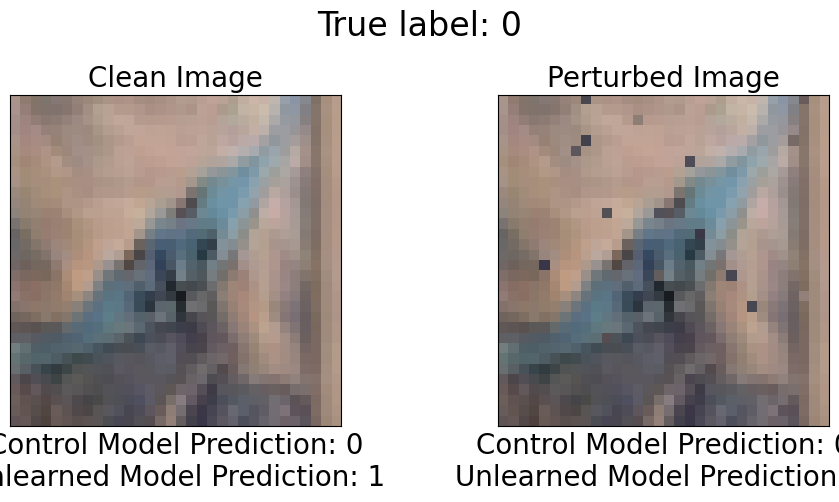

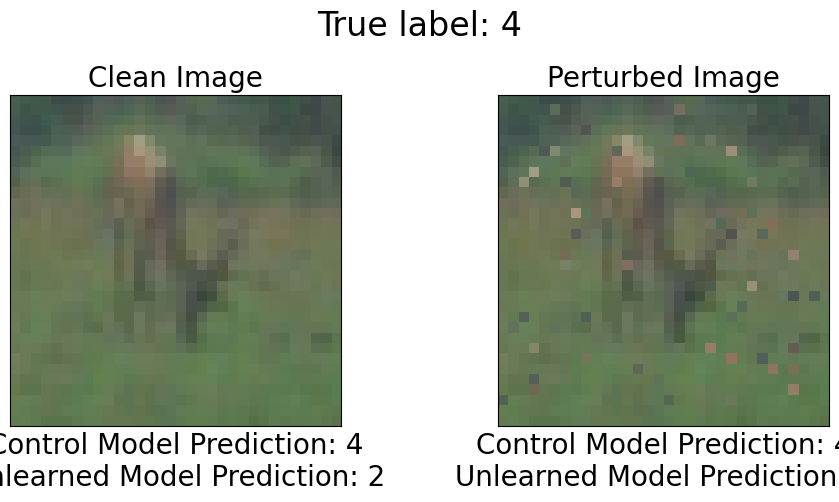

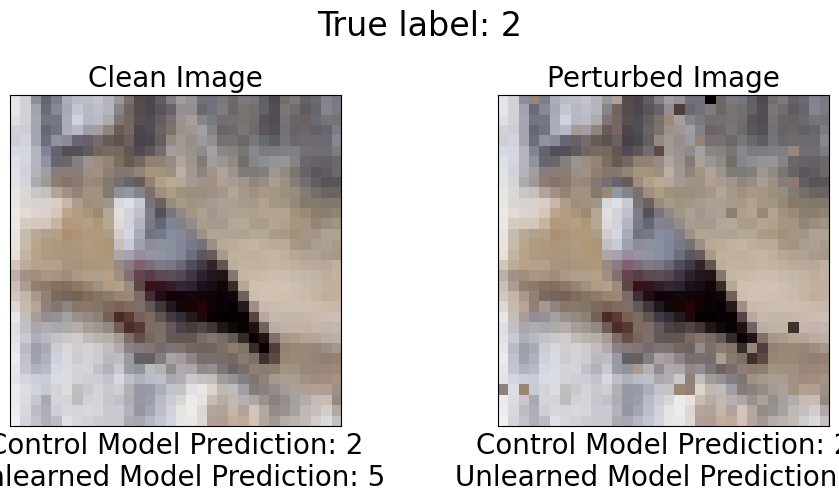

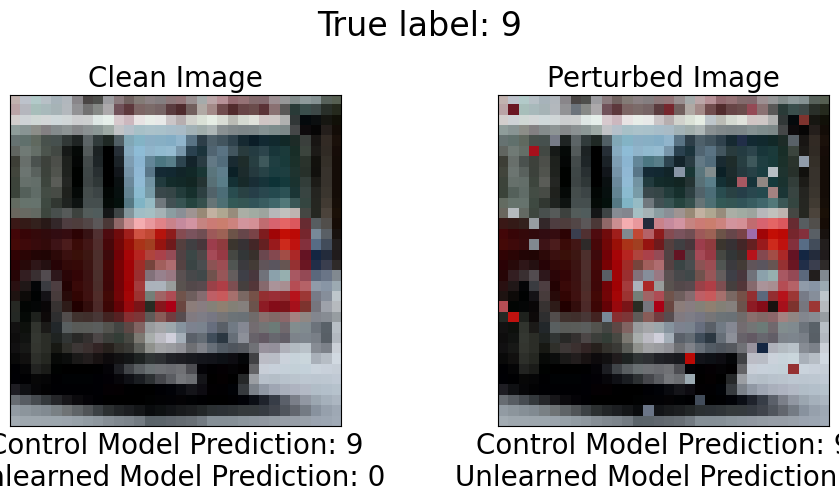

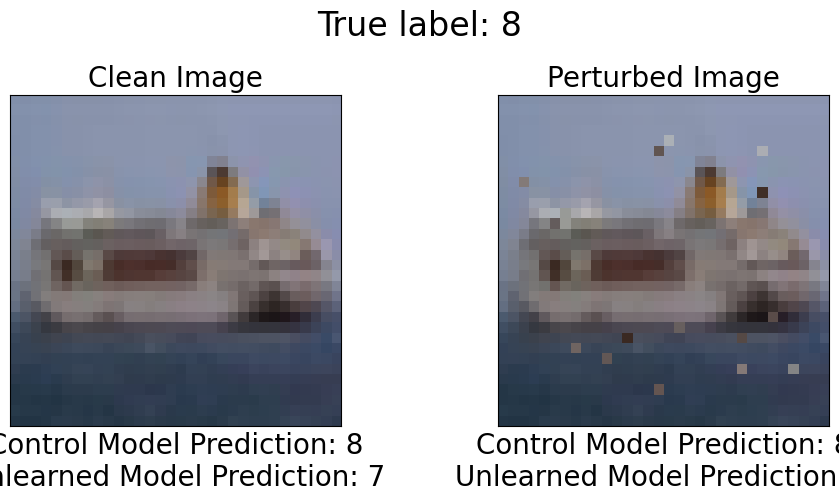

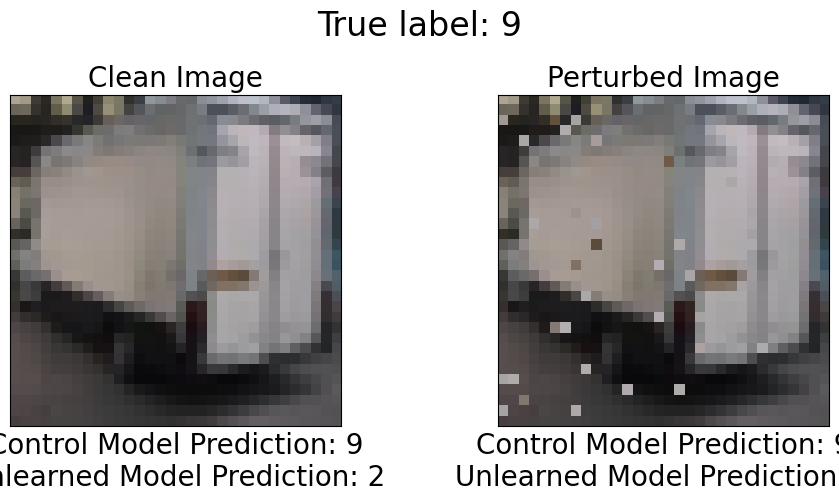

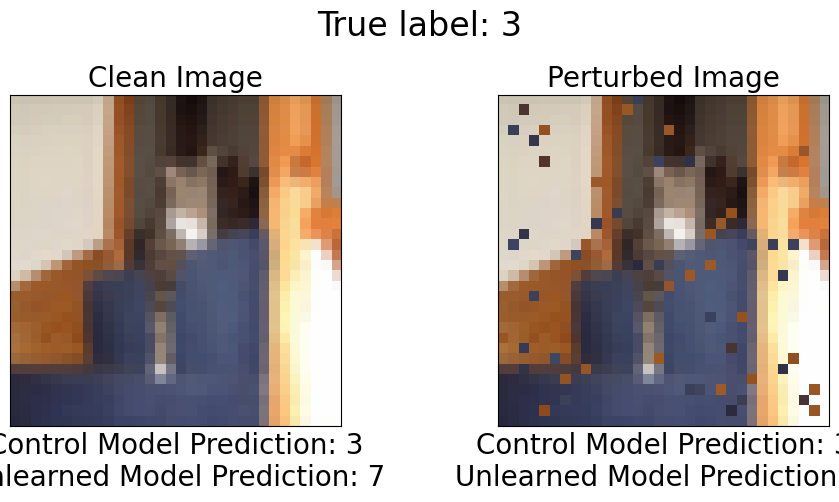

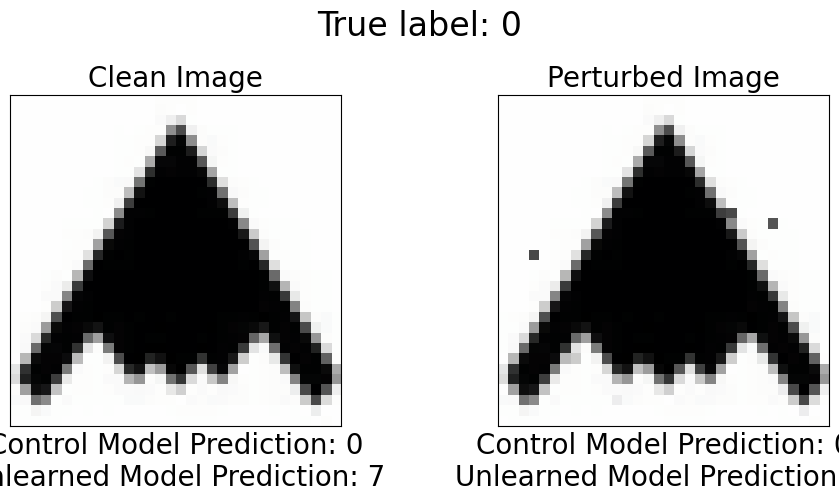

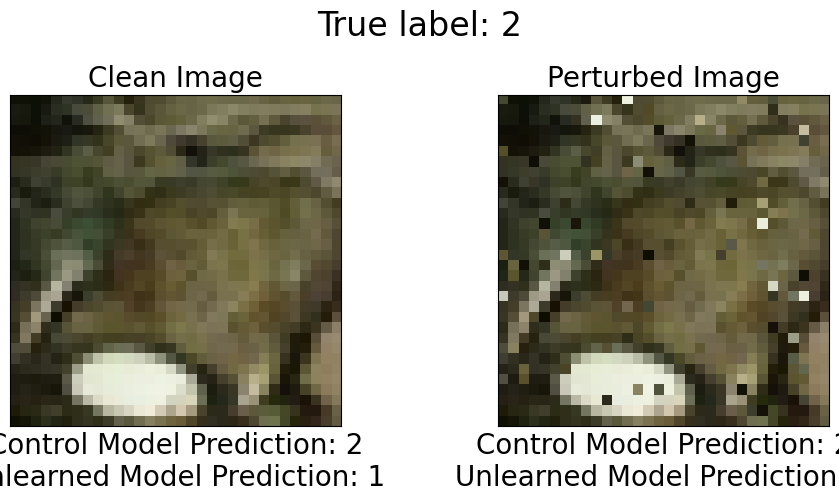

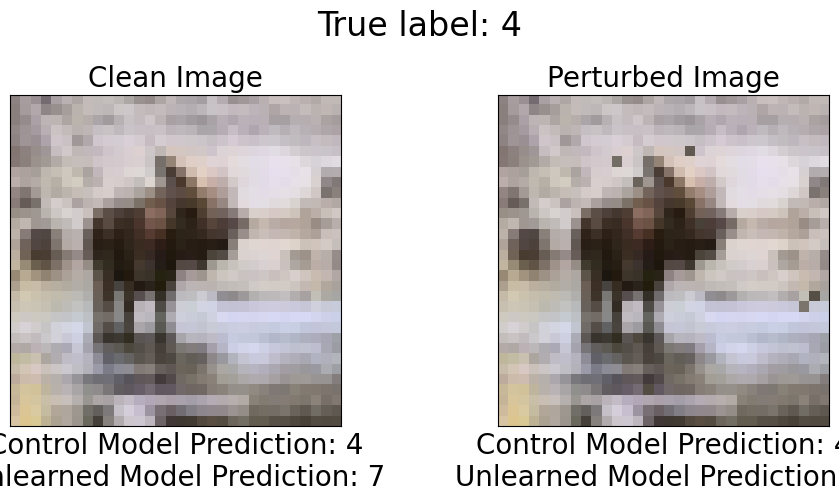

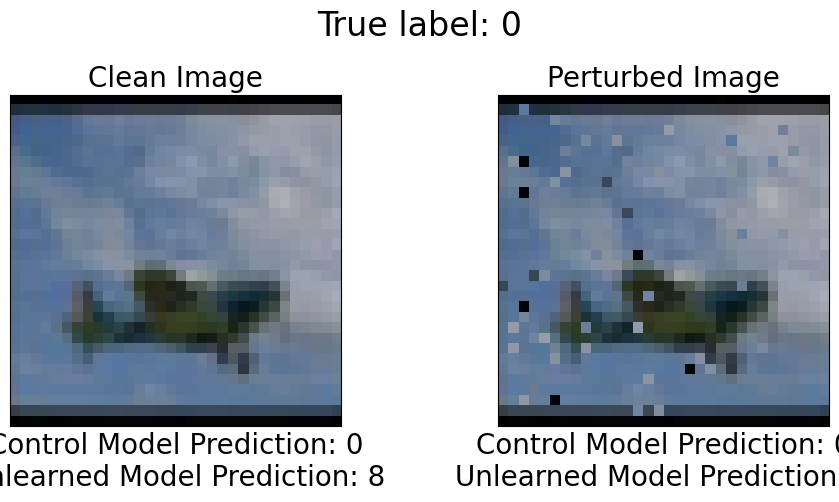

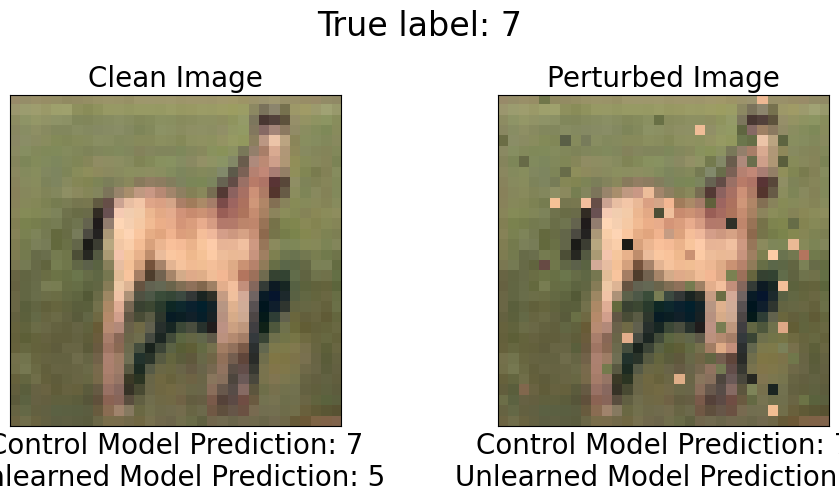

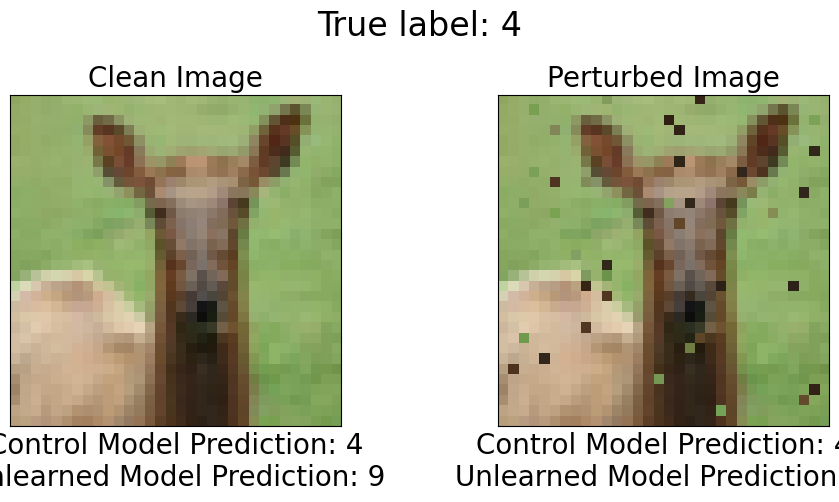

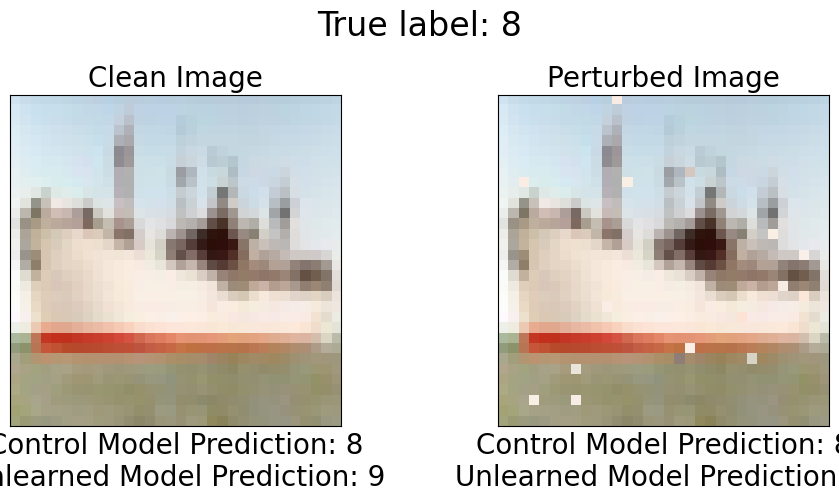

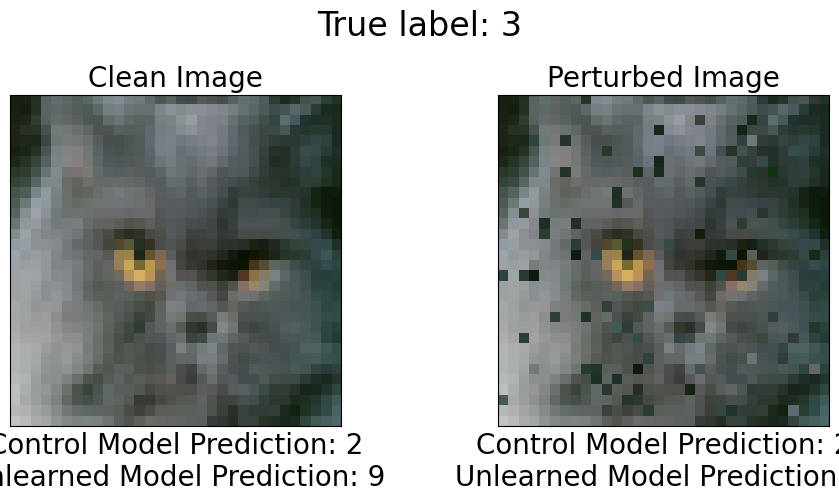

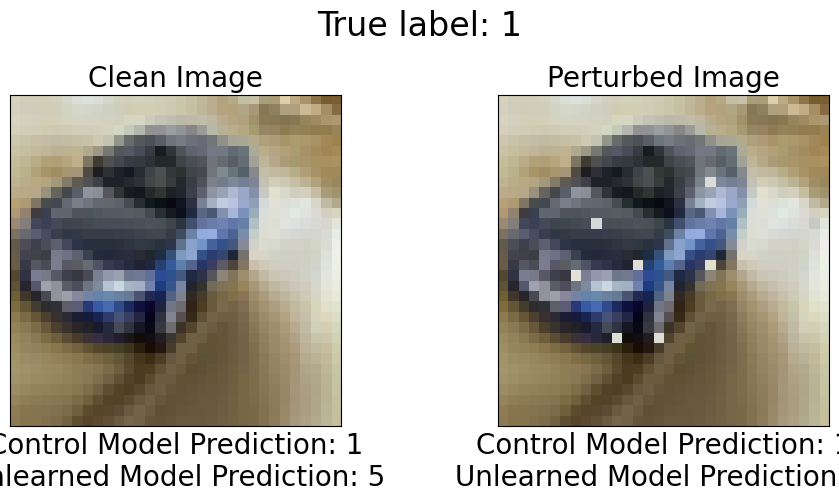

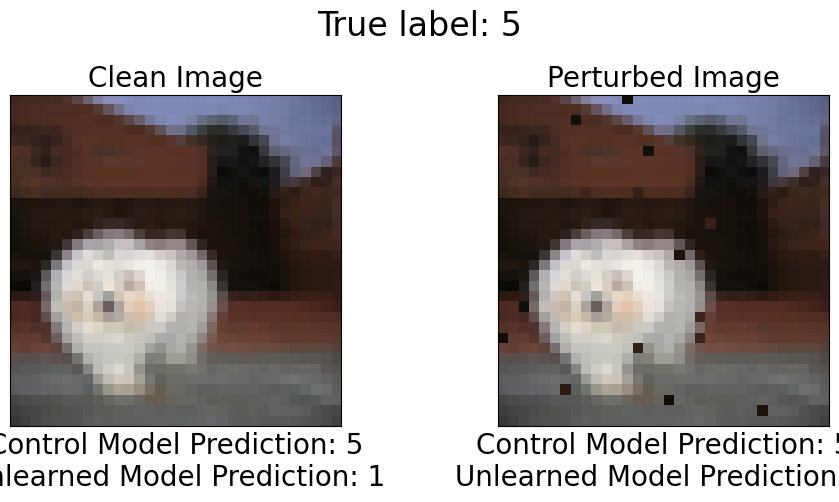

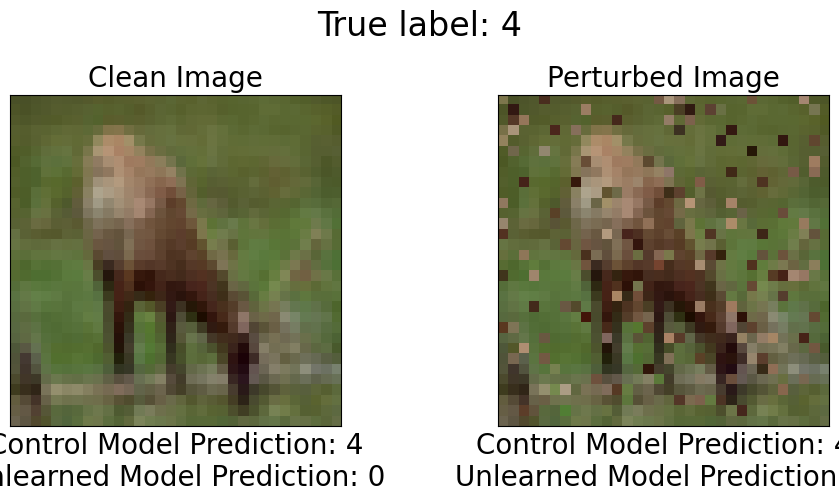

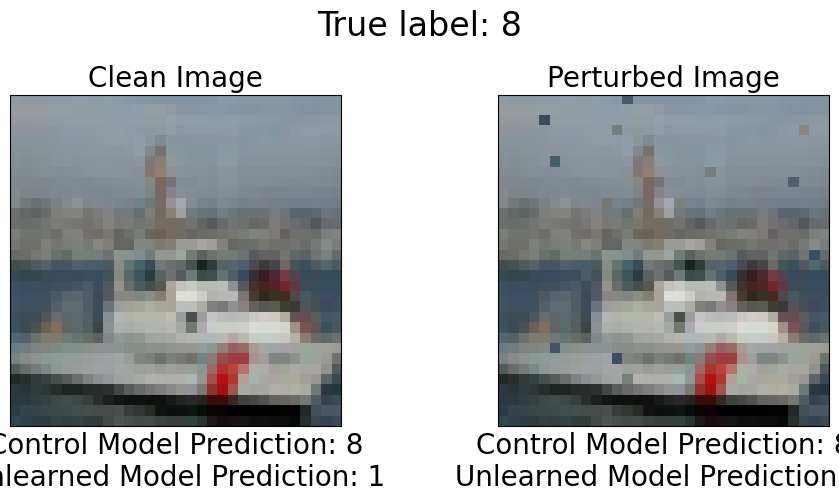

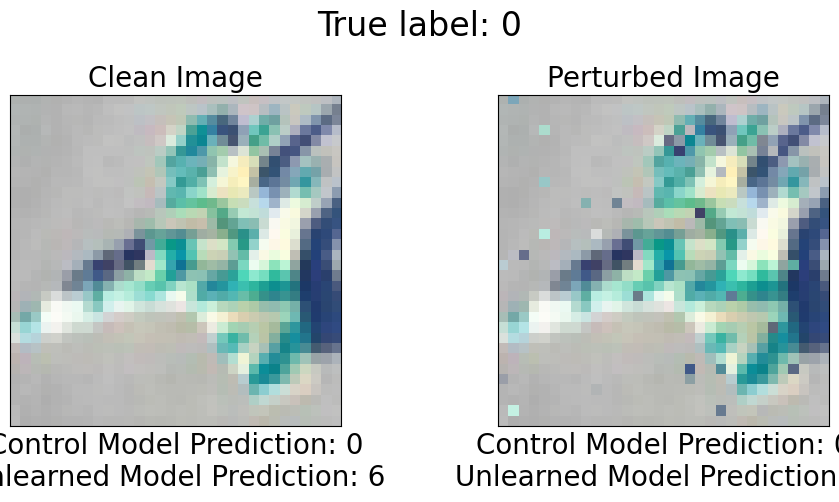

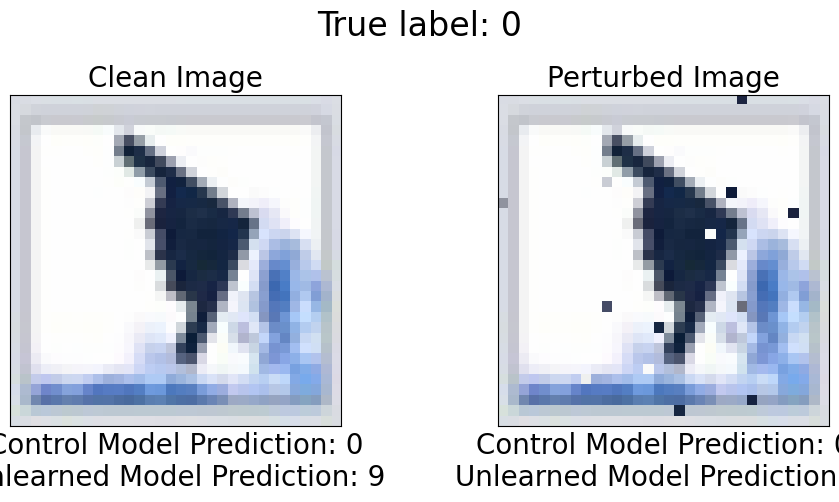

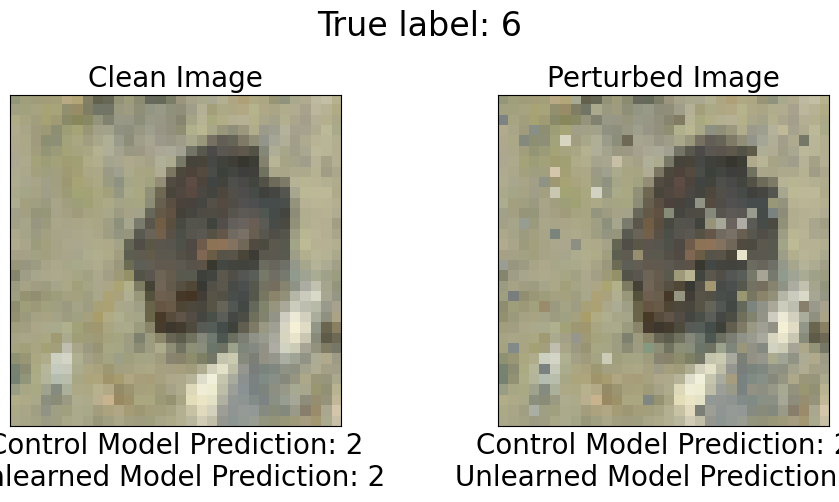

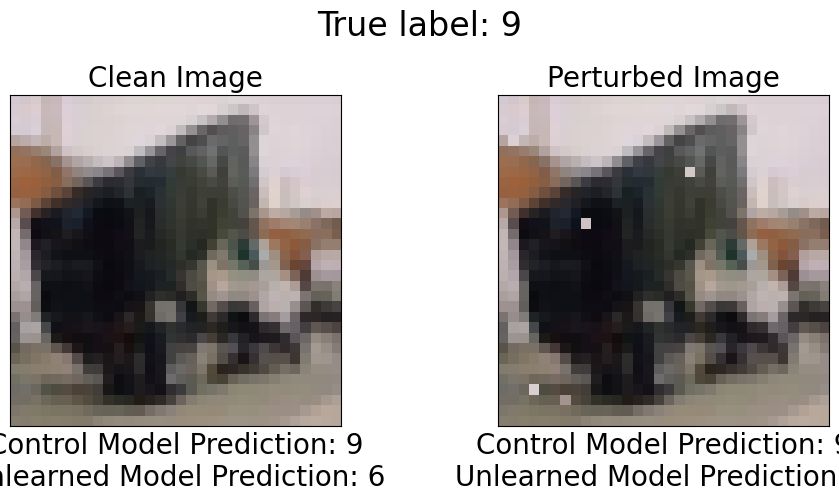

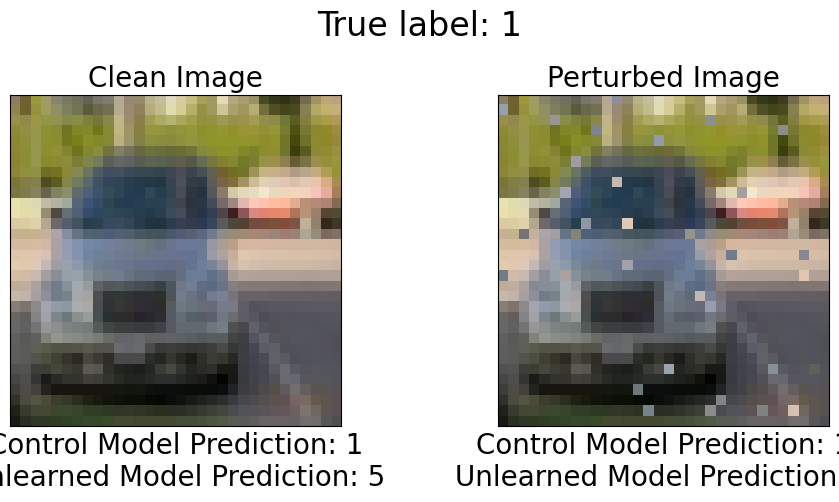

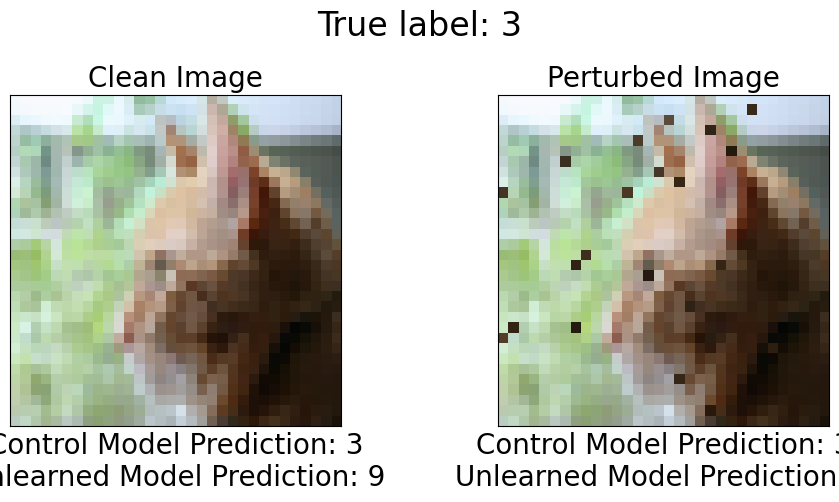

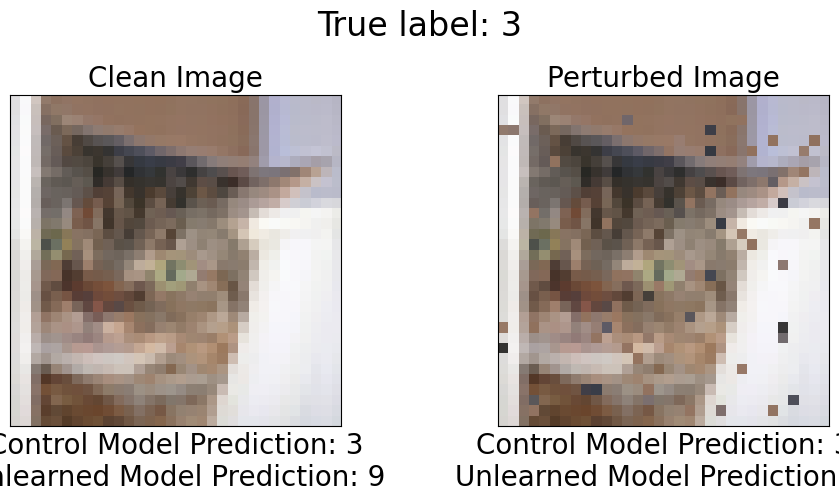

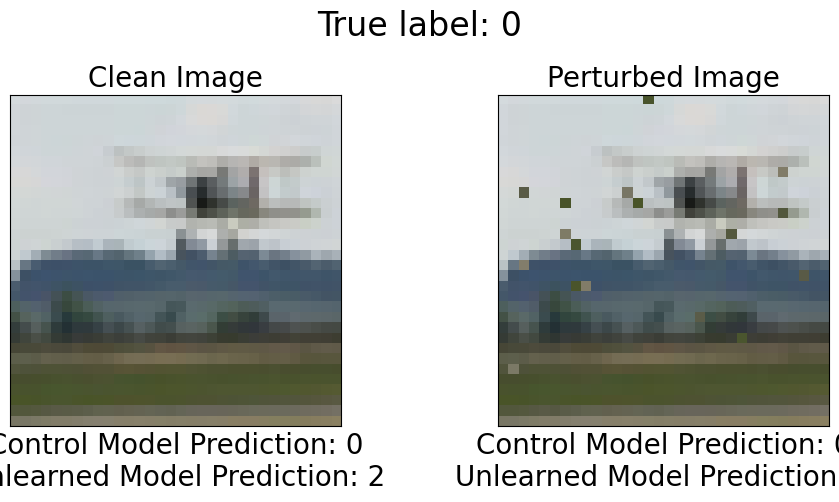

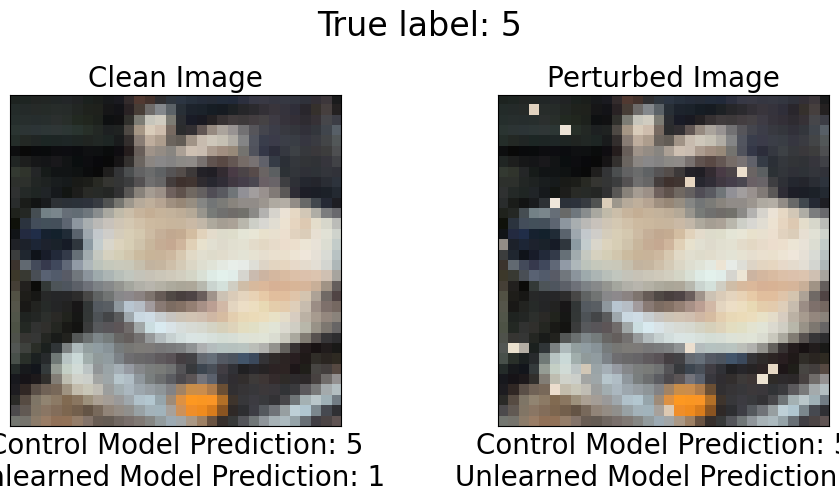

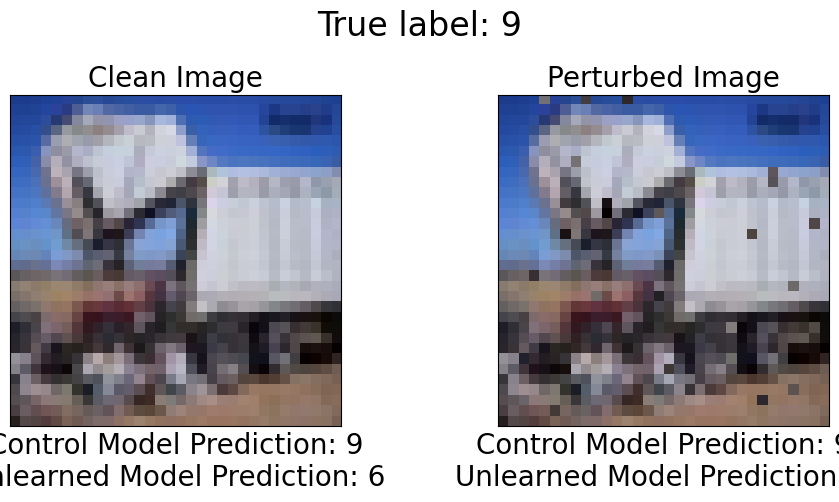

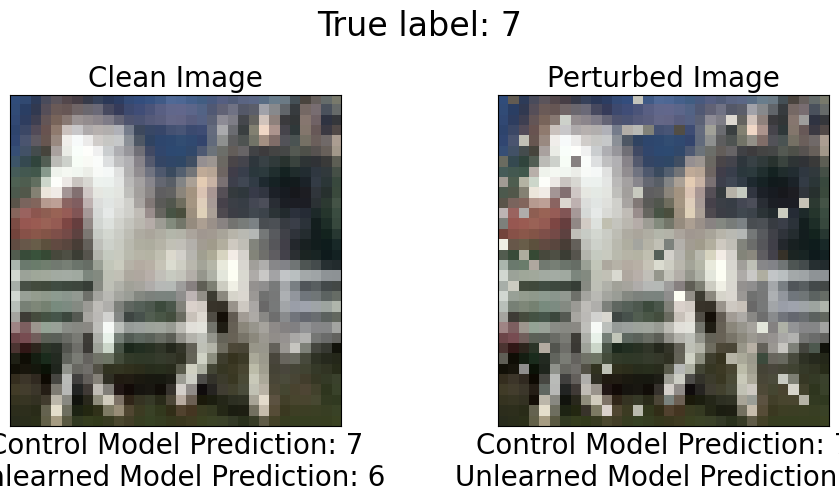

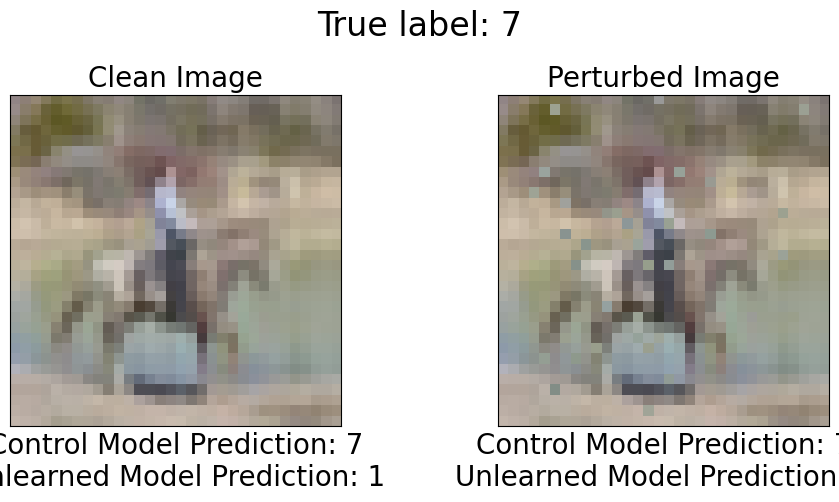

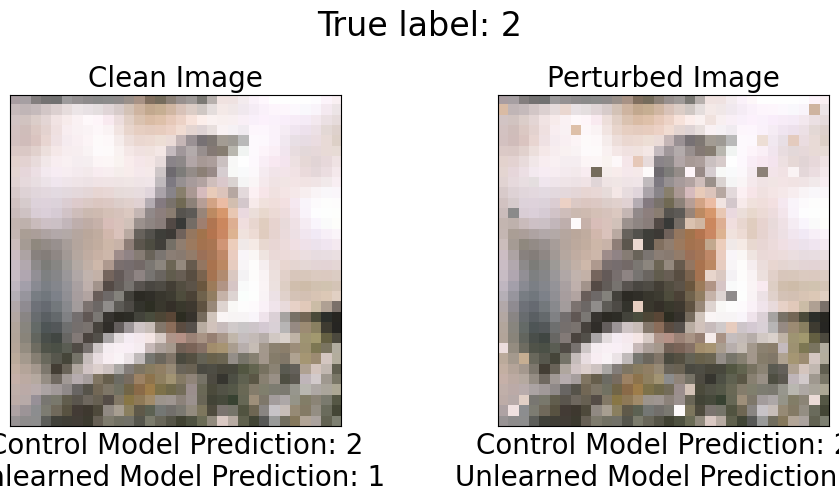

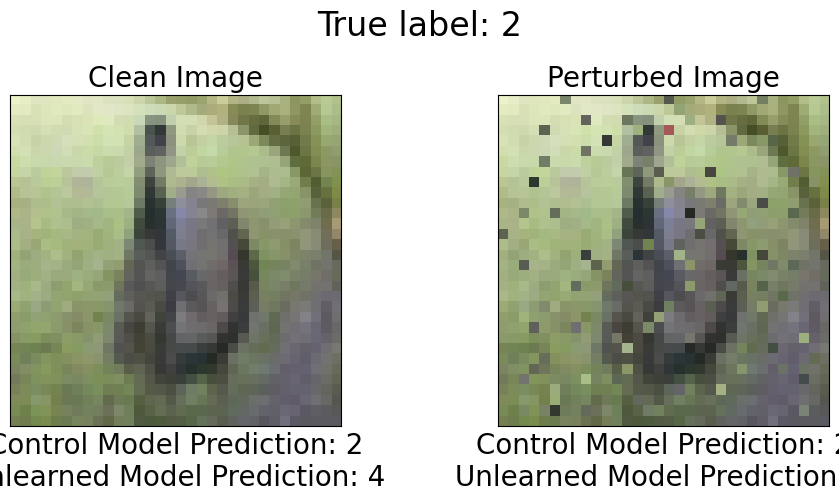

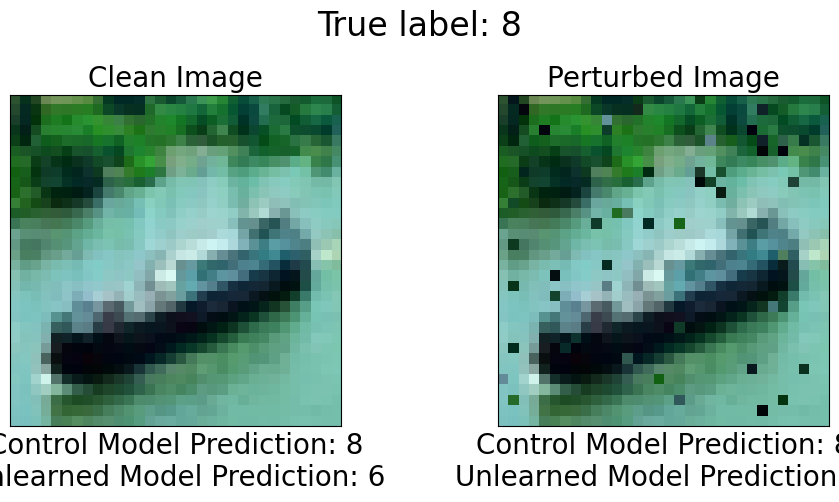

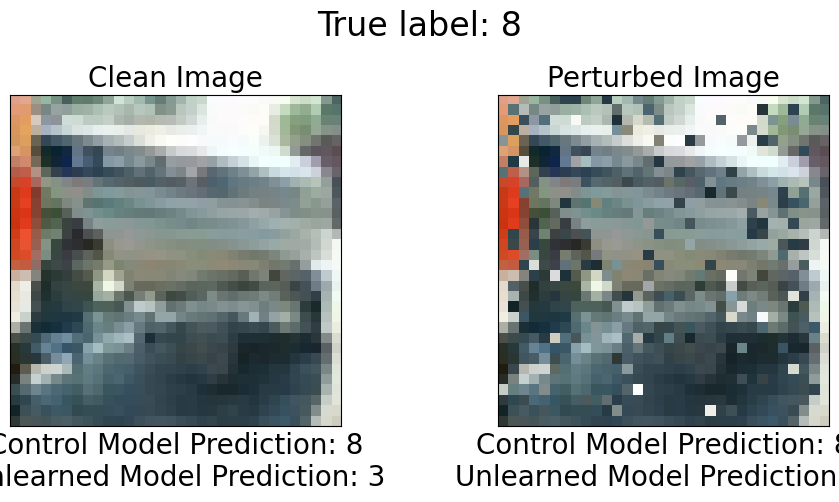

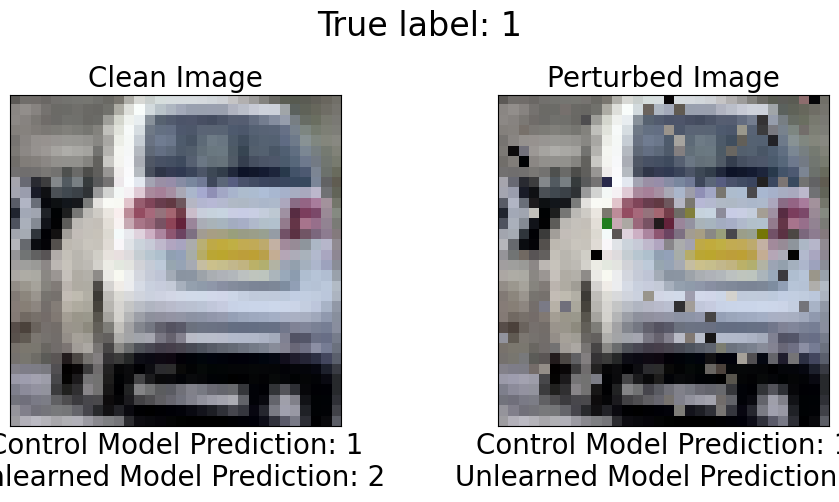

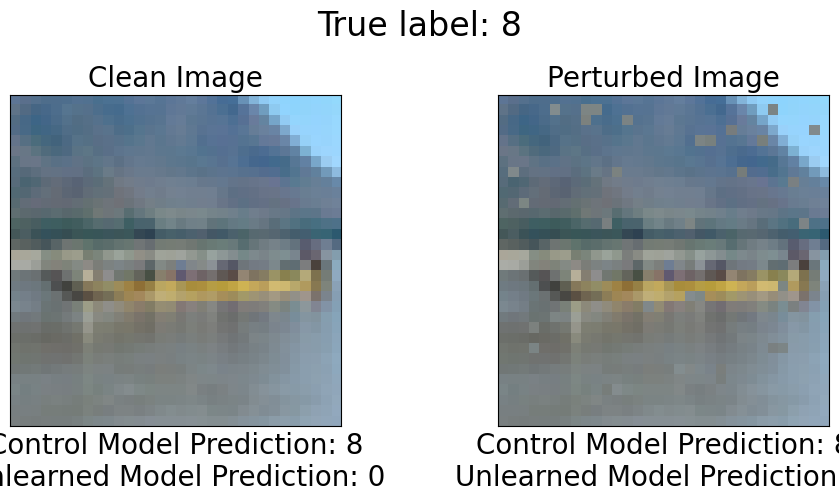

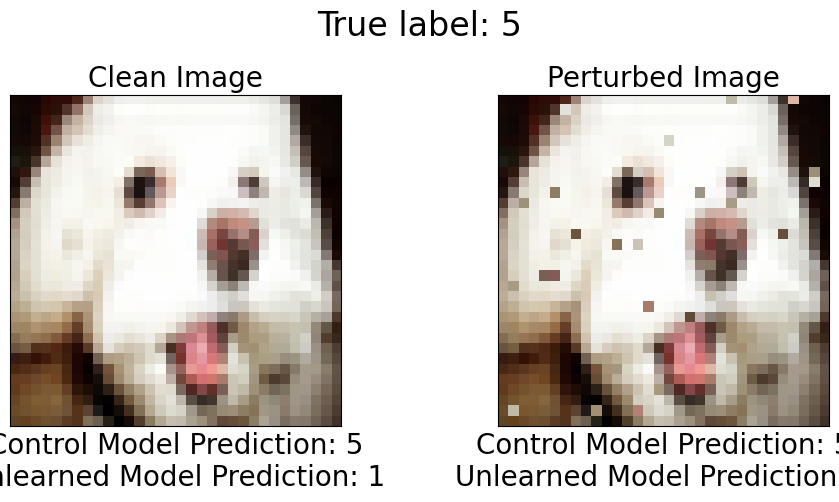

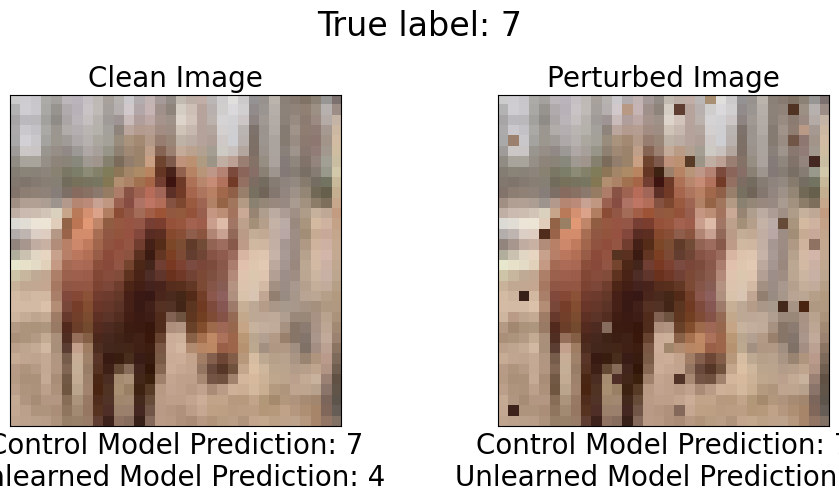

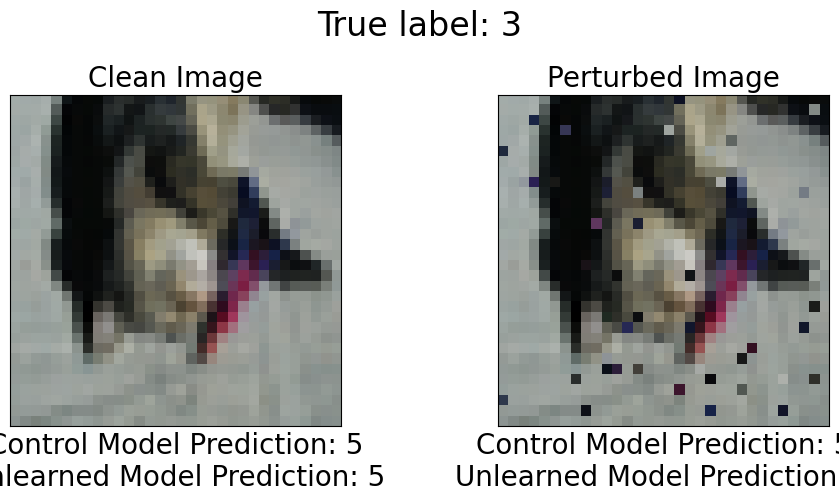

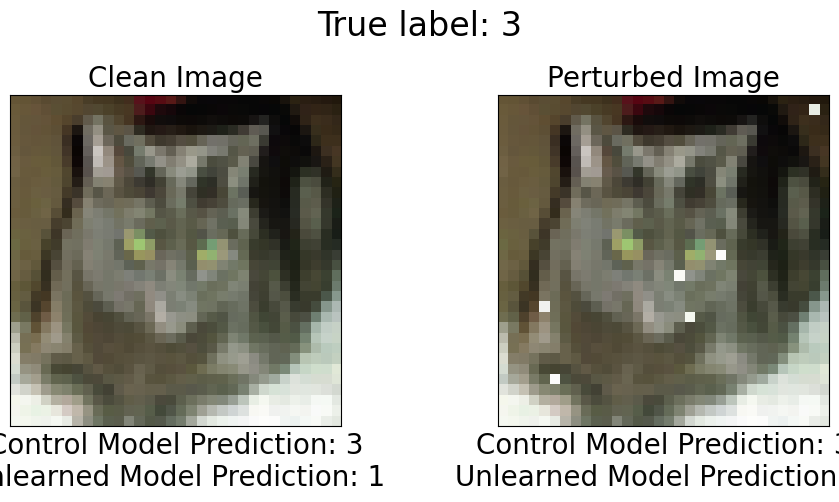

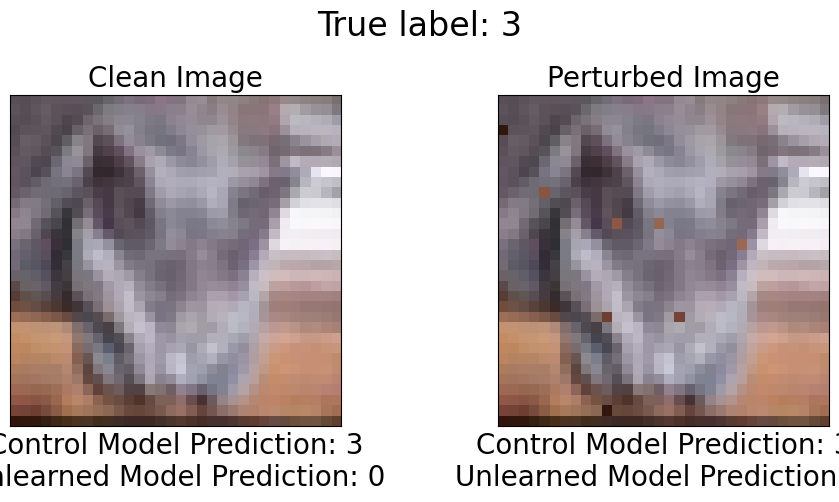

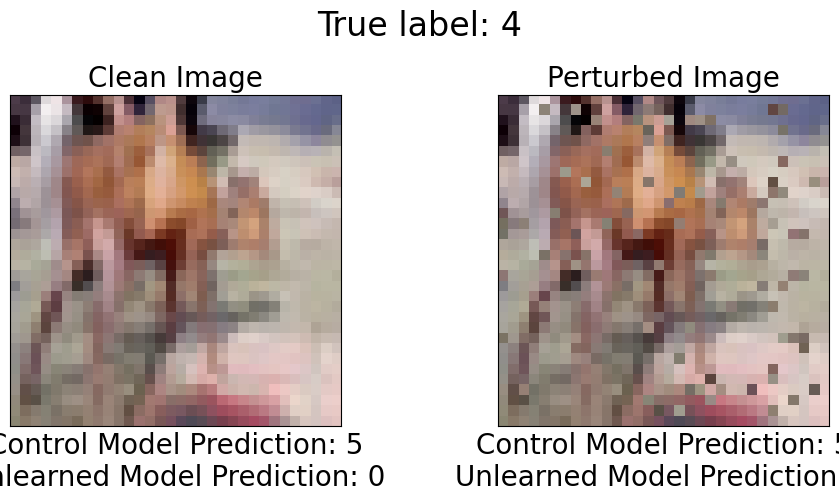

In [34]:
bad_indices = []
for i, (x, y) in enumerate(tqdm(clean_ds)):
    clean_pred = F.softmax(unlearned_model(x.reshape(1, 3, 32, 32).cuda()), dim=-1).view(-1).cpu().argmax(dim=-1)
    noisy_pred = F.softmax(unlearned_model(adv_imgs[i].reshape(1, 3, 32, 32).cuda()), dim=-1).view(-1).cpu().argmax(dim=-1)
    if clean_pred != y and noisy_pred == y:
        bad_indices.append(i)
print(f'Found {len(bad_indices)} examples of recovered behavior')

for i, ind in enumerate(tqdm(bad_indices)):
    img, label = clean_ds[ind]
    noisy_img = adv_imgs[ind]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f'True label: {label}')
    
    plot_img(img, ax1)
    ax1.set(
        title='Clean Image',
        xlabel=f'Control Model Prediction: {F.softmax(control_model(img.reshape(1, 3, 32, 32).cuda()), dim=-1).view(-1).cpu().argmax(dim=-1)}\nUnlearned Model Prediction: {F.softmax(unlearned_model(img.reshape(1, 3, 32, 32).cuda()), dim=-1).view(-1).cpu().argmax(dim=-1)}',
        xticks=[], 
        yticks=[] 
    ) 
    
    plot_img(noisy_img, ax2)
    ax2.set(
        title=f'Perturbed Image',
        xlabel=f'Control Model Prediction: {F.softmax(control_model(img.reshape(1, 3, 32, 32).cuda()), dim=-1).view(-1).cpu().argmax(dim=-1)}\nUnlearned Model Prediction: {F.softmax(unlearned_model(noisy_img.reshape(1, 3, 32, 32).cuda()), dim=-1).view(-1).cpu().argmax(dim=-1)}',
        xticks=[],
        yticks=[]
    )
    fig.tight_layout()
    fig.savefig(f'/home/mathepa1/vscode-projects/mirror-mirror/mia_counterexamples/img_{i}.png')
fig.show()